In [920]:
#!pip install missingno

In [921]:

import numpy as np
import os 
import pandas as pd
#from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
#import pyodbc
import seaborn as sns
sns.set()
#plt.style.use('seaborn')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import warnings
import datetime
warnings.filterwarnings("ignore")
import nltk
#nltk.download('popular')
nltk.download('punkt')
nltk.download('wordnet')





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [922]:
df_panel = pd.read_pickle('df_panel.pkl')
df_panel['Reviews'] = df_panel['Reviews'].replace(0, np.nan)
# Get only the numerical columns
cols= [
    'Accomodates',
    'Bathrooms', 
    'Bedrooms', 
    'Beds', 
    'Guests Included', 
    'Min Nights', 
    'Reviews', 
    'Overall Rating', 
    'Accuracy Rating',
    'Cleanliness Rating', 
    'Checkin Rating', 
    'Communication Rating',
    'Location Rating', 
    'Value Rating' ,
    'Latitude' ,
    'Longitude',
    'Host Response Rate'
 #   'Postal Code_n'
      ]
numerical_df = df_panel[cols]
#numerical_df = df_panel.select_dtypes(include=['number'])
df_panel.columns

Index(['Listing ID', 'Listing Name', 'Host ID', 'Host Name', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'neighbourhood',
       'Neighborhood Group', 'City', 'Country Code', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accomodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Price', 'Guests Included', 'Min Nights', 'Reviews',
       'First Review', 'Last Review', 'Overall Rating', 'Accuracy Rating',
       'Cleanliness Rating', 'Checkin Rating', 'Communication Rating',
       'Location Rating', 'Value Rating', 'Is Superhost_ind',
       'Is Exact Location_ind', 'Postal Code_n', 'Top10Neighbourhood',
       'Property Type_groups'],
      dtype='object')

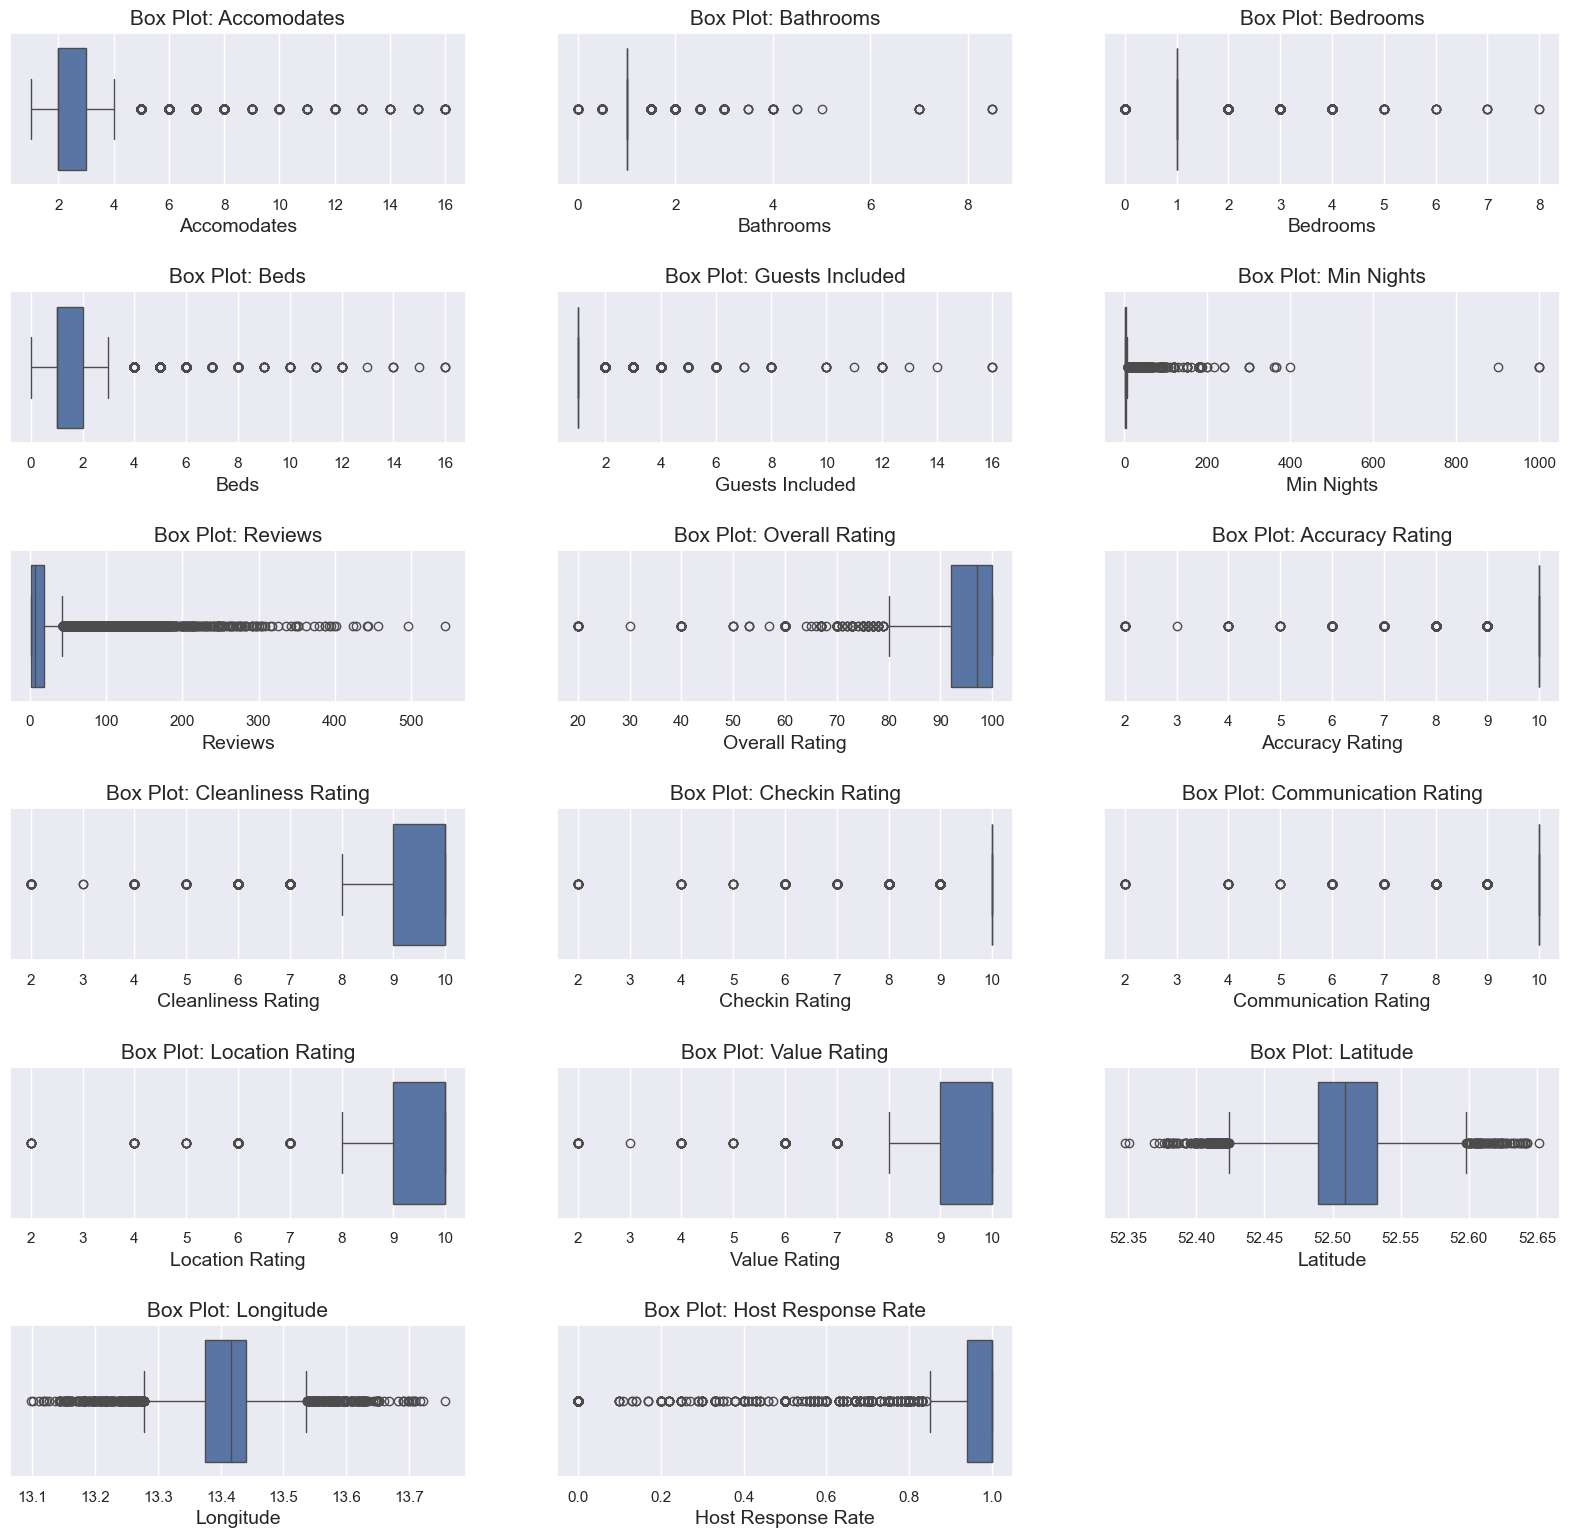

In [923]:
## Using box (Wiskers) plot 
plt.figure(figsize=(20,200))

def outliers_boxplot(animals):
    for i, col in enumerate(animals.columns):
        
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=animals, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)
        
outliers_boxplot(numerical_df)

Creating Nulls dataframe and matrix

In [924]:
df_nulls = df_panel.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14251 entries, 65536 to 456958
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Listing Name          14226 non-null  string        
 1   Host Name             14238 non-null  string        
 2   Host Since            14238 non-null  datetime64[ns]
 3   Host Response Time    8598 non-null   string        
 4   Host Response Rate    8598 non-null   float64       
 5   City                  14248 non-null  string        
 6   Bathrooms             14235 non-null  float64       
 7   Bedrooms              14237 non-null  float64       
 8   Beds                  14227 non-null  float64       
 9   Reviews               11467 non-null  float64       
 10  First Review          11467 non-null  datetime64[ns]
 11  Last Review           11467 non-null  datetime64[ns]
 12  Overall Rating        11184 non-null  float64       
 13  Accuracy Rating 

<Axes: >

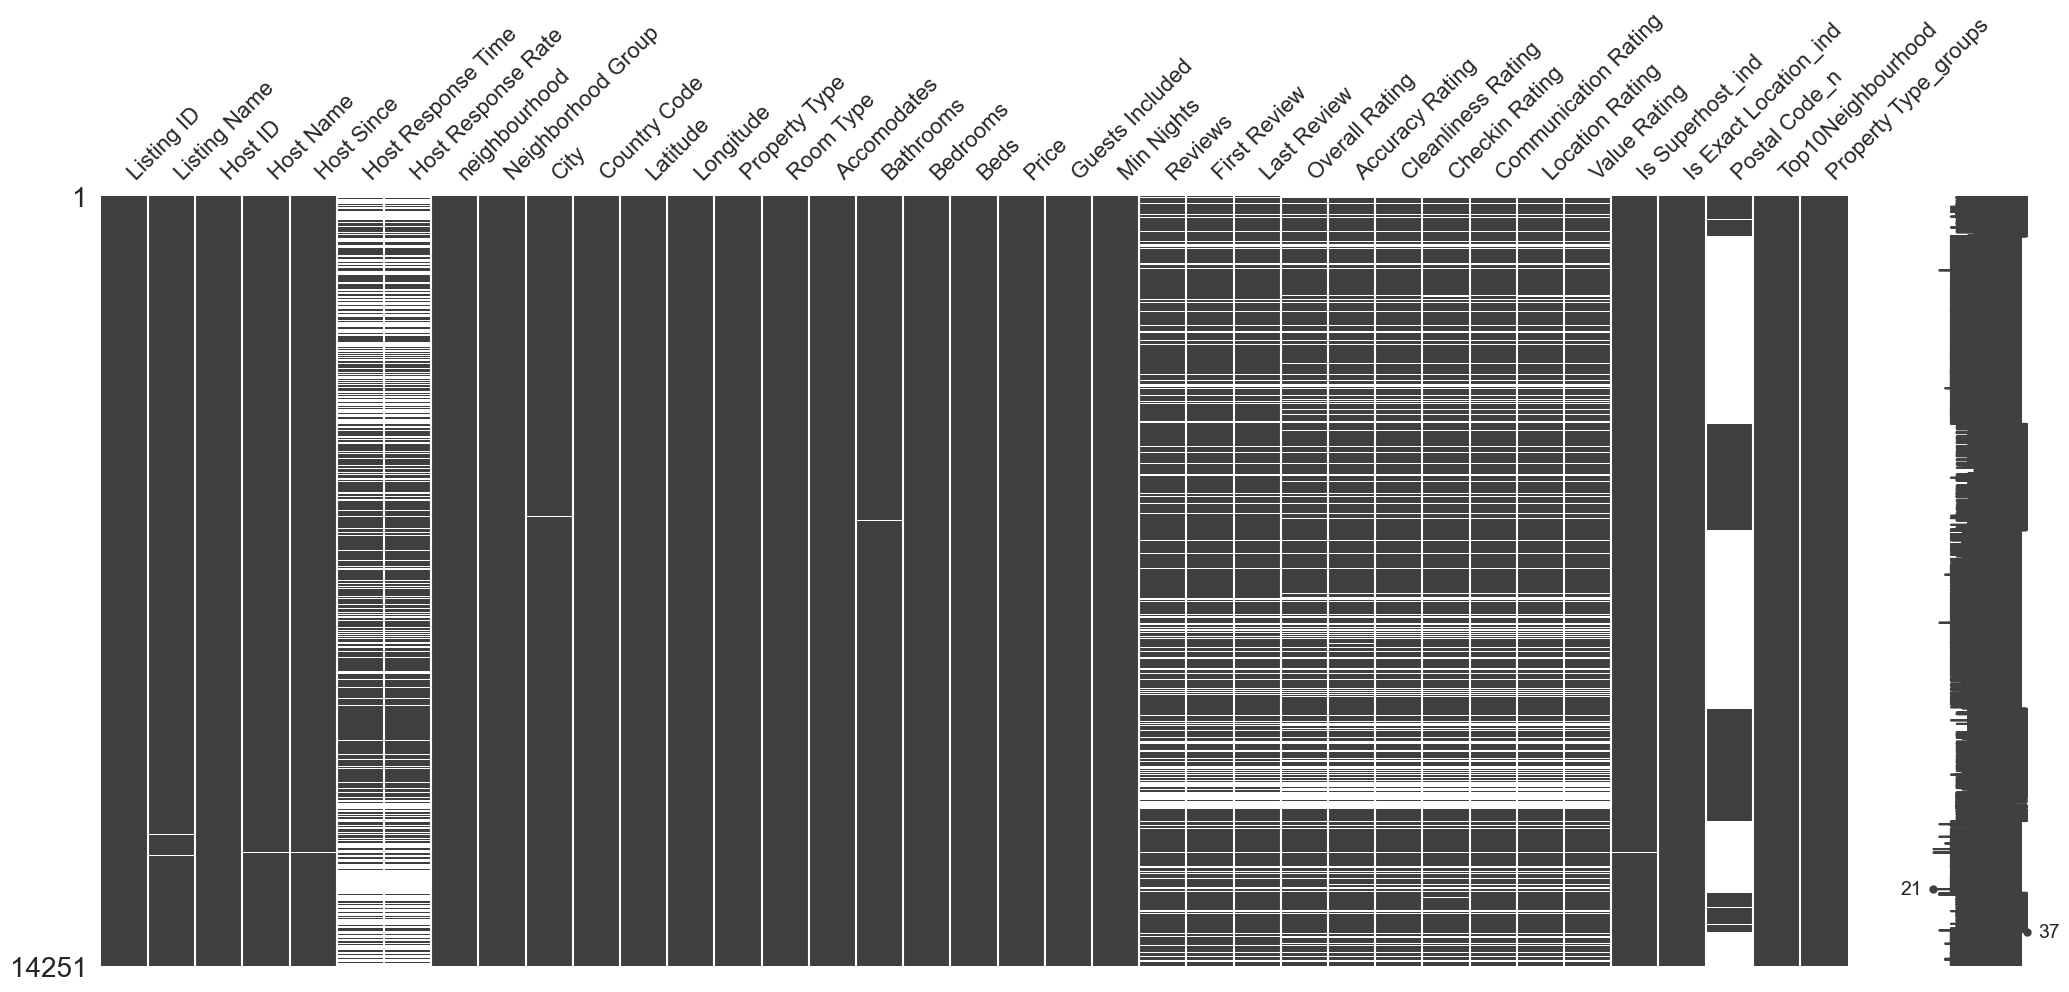

In [925]:

msno.matrix(df_panel)

In [926]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

,Missing Values,% of Total Values
Postal Code_n,8838,62.0
Host Response Time,5653,39.7
Host Response Rate,5653,39.7
Checkin Rating,3091,21.7
Value Rating,3090,21.7
Location Rating,3088,21.7
Communication Rating,3081,21.6
Accuracy Rating,3081,21.6
Cleanliness Rating,3077,21.6
Overall Rating,3067,21.5


<Axes: >

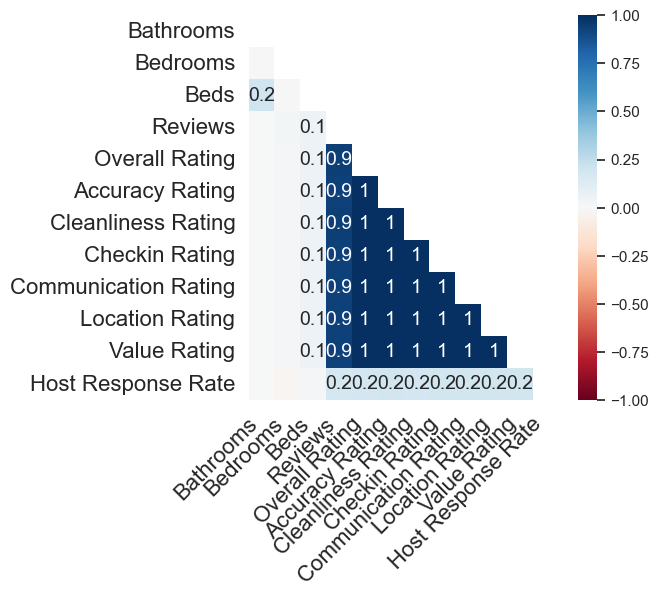

In [927]:

df_num_na=numerical_df.isna()
df_num_na
msno.heatmap(numerical_df,figsize=(5,5))

# Outliers

In [928]:
import pandas as pd

def total_outliers_df(df):
    # Corrected: Use a list for columns
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])
    
    for col in df.columns:
        if col != 'Price':
            temp = pd.DataFrame(df[col])
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            upper_limit = Q3 + 1.5 * (Q3 - Q1)
            lower_limit = Q1 - 1.5 * (Q3 - Q1)
            upper_outliers = temp[temp[col] > upper_limit]
            lower_outliers = temp[temp[col] < lower_limit]
            temp = pd.concat([upper_outliers, lower_outliers])
            
            # Use .loc to correctly assign values to the DataFrame
            total_outliers.loc[col] = [len(temp), len(temp)/len(df)*100]
    
    # Filter and sort the resulting DataFrame
    return total_outliers[total_outliers['Percent'] > 0]

# Example usage
# Replace numerical_df with your actual DataFrame
df_ttl_outliers = total_outliers_df(numerical_df).sort_values('Percent', ascending=False)
df_ttl_outliers

,Outlier count,Percent
Bedrooms,3628.0,25.457863
Guests Included,3216.0,22.566837
Accuracy Rating,2557.0,17.942601
Checkin Rating,2167.0,15.205950
Communication Rating,1984.0,13.921830
Bathrooms,1680.0,11.788646
Min Nights,1480.0,10.385236
Host Response Rate,1388.0,9.739667
Reviews,1339.0,9.395832
Accomodates,1307.0,9.171286


In [929]:

df_ttl_outliers.to_csv('outliers_df.csv')

In [930]:
# Function to identify and treat outliers using IQR
def treat_outliers(df, features):
    df_outliers = pd.DataFrame(index=df.index)
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[feature] = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).astype(int)
    return df_outliers

outliers_df=treat_outliers(df_panel,cols)
outliers_df

,Accomodates,Bathrooms,Bedrooms,Beds,Guests Included,Min Nights,Reviews,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Latitude,Longitude,Host Response Rate
65536,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
65603,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65625,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
65626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65627,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456582,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
456585,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
456605,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
456954,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [931]:
def capping(df):
    temp = df.copy()
    for col in temp:
        if col in df_ttl_outliers.index:
            Q1 = temp[col].quantile(0.25)
            Q3 = temp[col].quantile(0.75)
            upper_limit = Q1 + 1.5 * (Q3-Q1)
            lower_limit = Q3 - 1.5 * (Q3-Q1)
            temp[col] = np.where(temp[col] > upper_limit,np.nan,np.where(temp[col] < lower_limit,np.nan,temp[col]))
    return temp
cap_df = capping(df_panel)
cap_df.to_csv('outliers_cap_df.csv')
cap_df



,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,neighbourhood,Neighborhood Group,City,...,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Is Superhost_ind,Is Exact Location_ind,Postal Code_n,Top10Neighbourhood,Property Type_groups
65536,13761071,Central apartment near Alex (Apt. 9),80675177,Sven,2016-06-29,within a few hours,1.0,Mitte,Mitte,Berlin,...,10.0,10.0,10.0,10.0,9.0,1,1,10179,Mitte,Apartment
65603,13763834,"SchÃ¶ne, helle Whg nahe Tempelh. Feld in NeukÃ...",80714211,Renald,2016-06-29,<NA>,NaN,NeukÃ¶lln,NeukÃ¶lln,Berlin,...,9.0,10.0,10.0,9.0,10.0,0,1,12051,NeukÃ¶lln,Apartment
65625,13764102,Cozy and quiet Loft in Central Berlin,80179711,Sonja,2016-06-27,<NA>,NaN,Mitte,Mitte,Berlin,...,NaN,NaN,NaN,NaN,NaN,0,1,10119,Mitte,Apartment
65626,13764166,"Cozy room in Berlin, Charlottenburg!",62639492,Eva,2016-03-12,<NA>,NaN,Charlottenburg,Charlottenburg-Wilm.,Berlin,...,10.0,10.0,10.0,10.0,10.0,0,1,10589,Charlottenburg,Apartment
65627,13765505,Small but nice and quite room,49985648,Janka,2015-11-27,<NA>,NaN,Prenzlauer Berg,Pankow,Berlin,...,10.0,10.0,10.0,10.0,10.0,0,0,10407,Prenzlauer Berg,Apartment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456582,9991497,"Chillout-Oase fÃ¼r ""GroÃ und Klein""",44816934,Luca,2015-09-22,<NA>,NaN,NiederschÃ¶neweide,Treptow - KÃ¶penick,Berlin,...,NaN,NaN,NaN,NaN,NaN,0,0,<NA>,Other,Apartment
456585,9993168,GemÃ¼tliches Zimmer zur Ãbernachtung,40660291,Anh,2015-08-06,<NA>,NaN,Rummelsburg,Lichtenberg,Berlin,...,10.0,10.0,NaN,9.0,9.0,0,0,<NA>,Other,Apartment
456605,9994644,Potsdamer Platz-Top Spot Studio 1,22276081,Martin,2014-10-08,within an hour,1.0,Kreuzberg,Friedrichshain-Kreuzberg,Berlin,...,10.0,10.0,10.0,10.0,10.0,1,1,<NA>,Kreuzberg,Apartment
456954,999465,Familyhome for your vacation,5494219,Simone,2013-03-17,<NA>,NaN,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,...,10.0,10.0,10.0,10.0,10.0,0,0,<NA>,Friedrichshain,Apartment


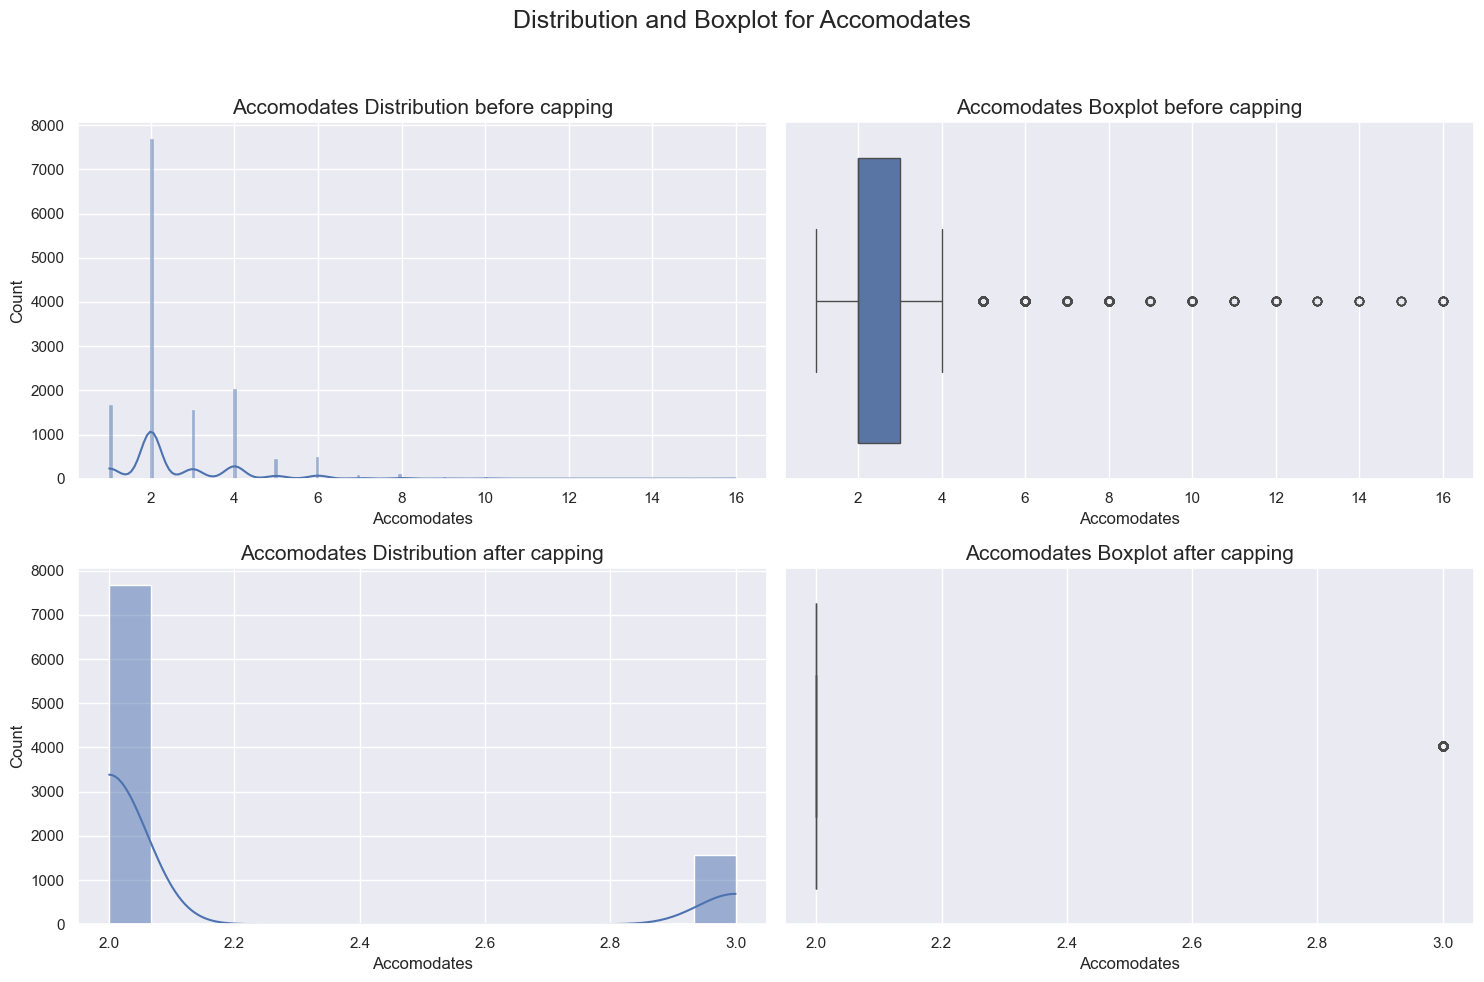

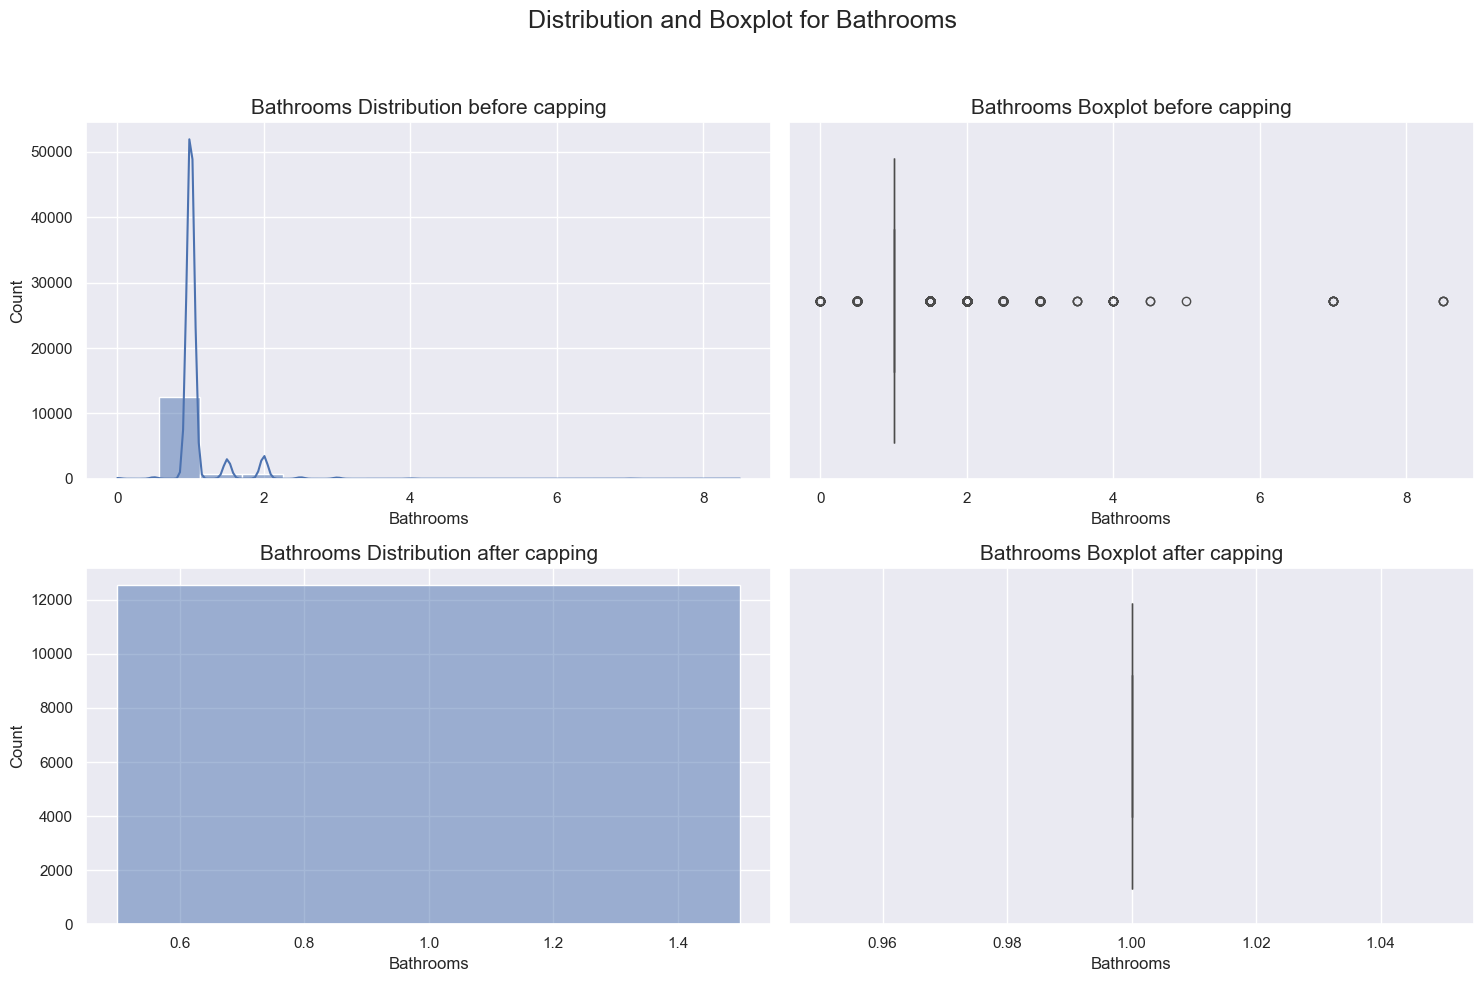

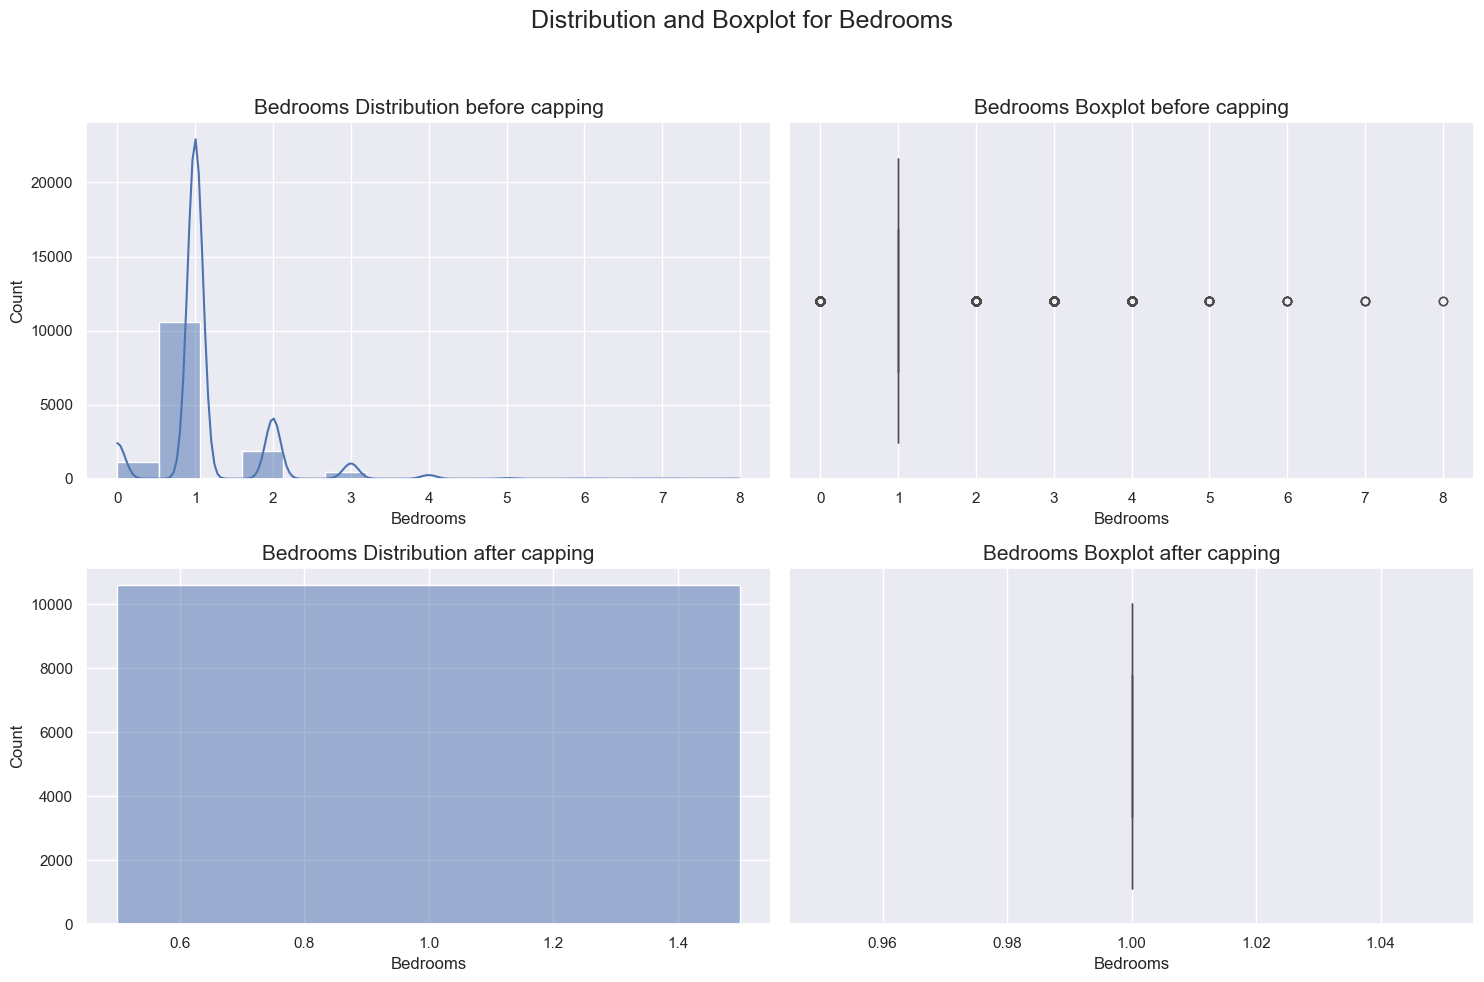

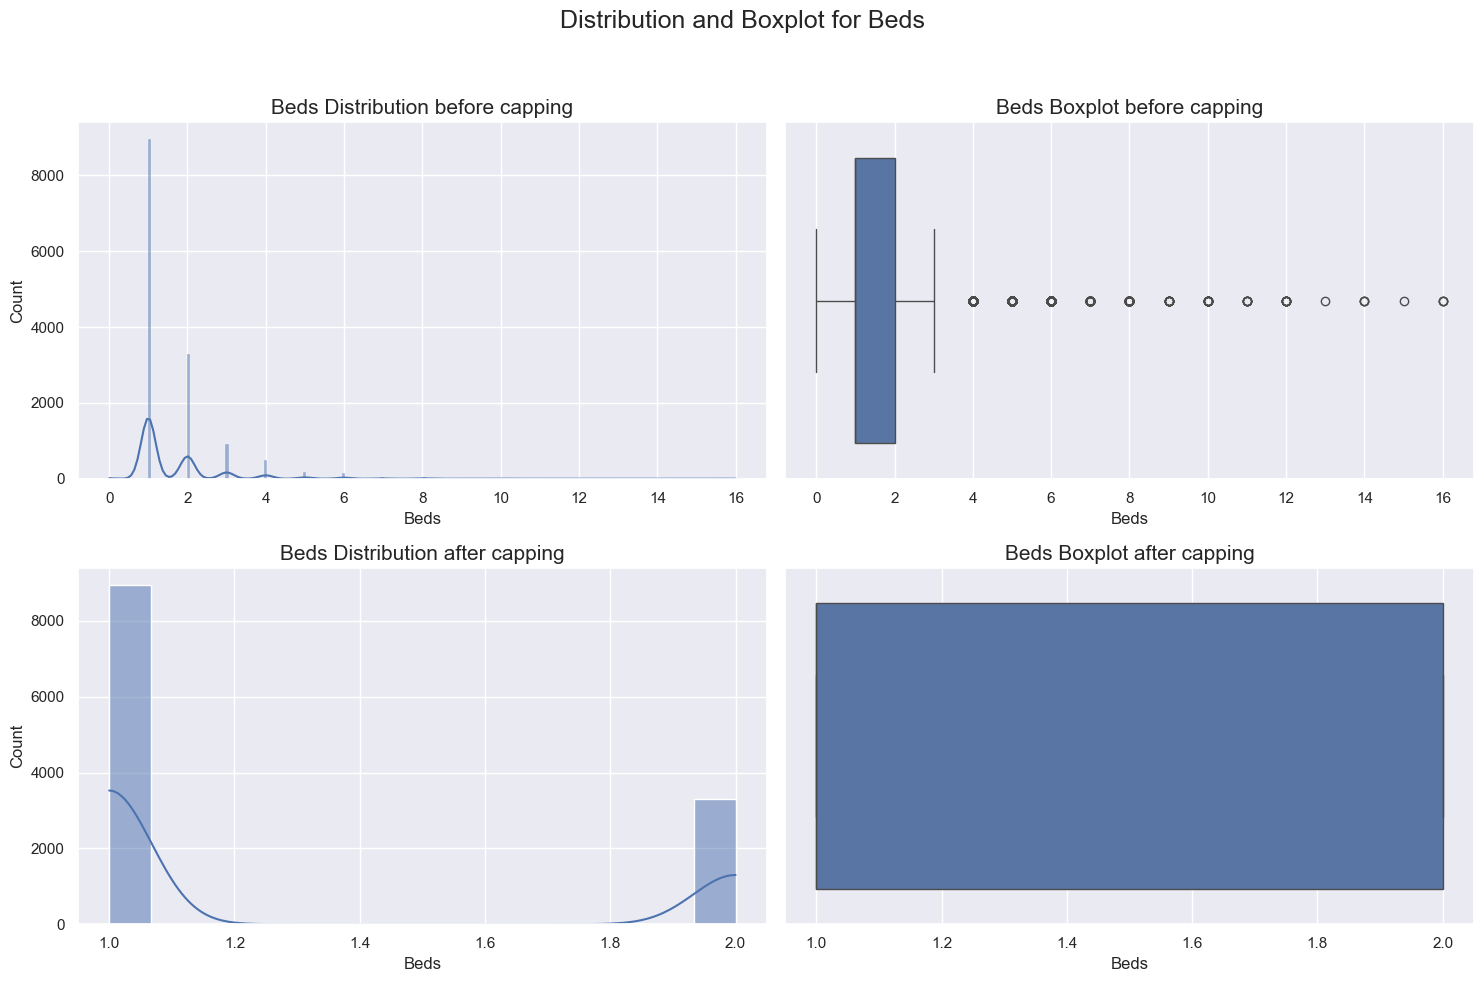

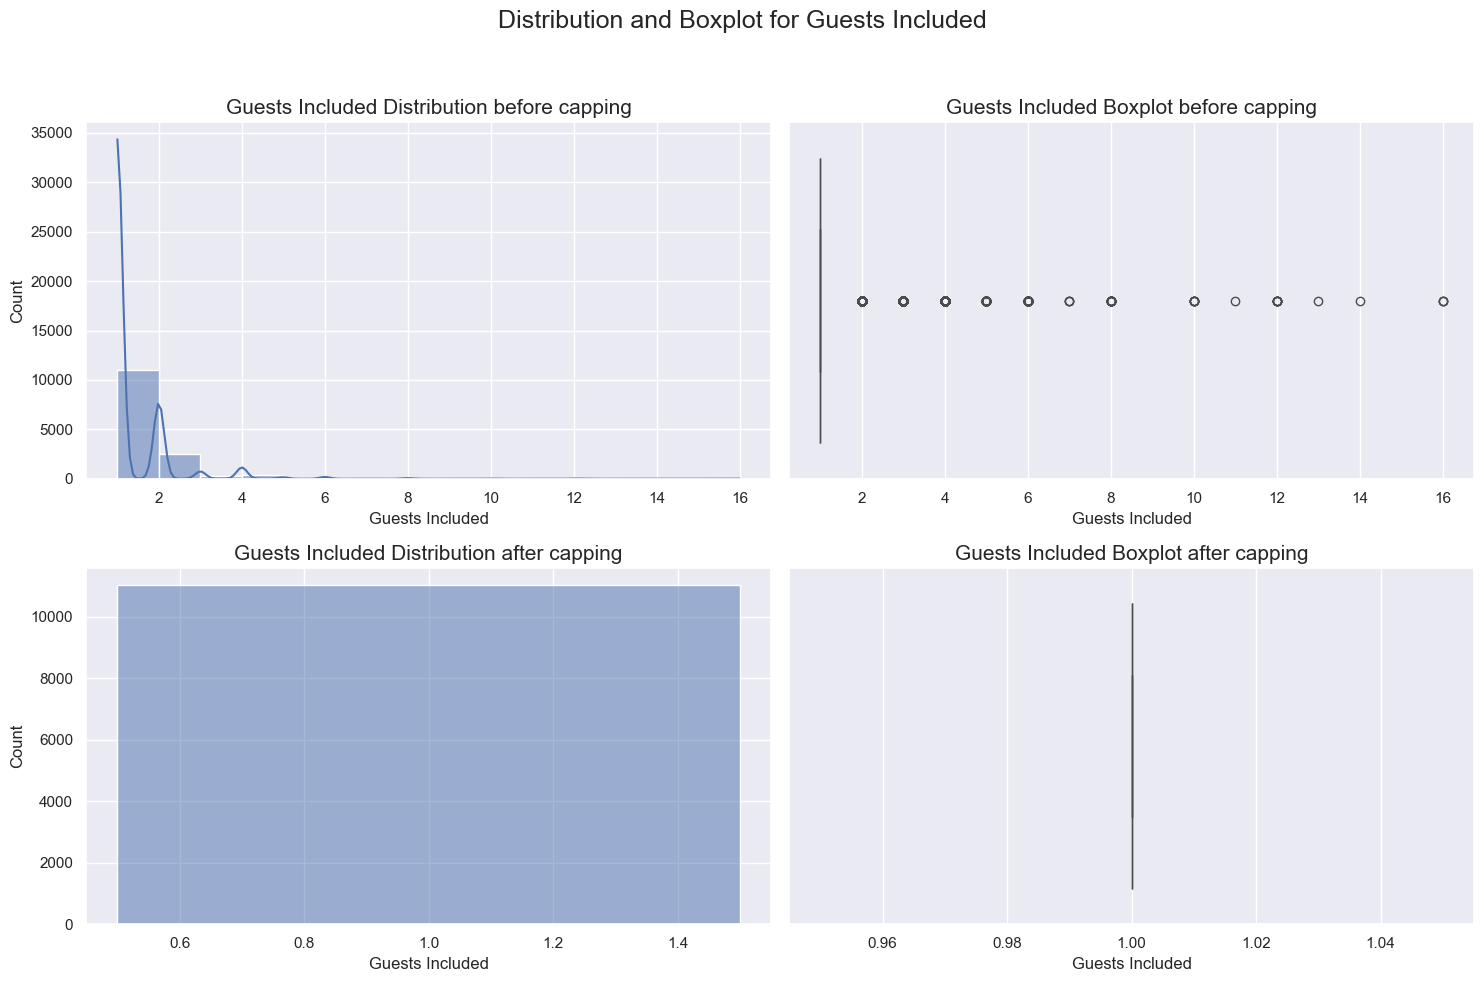

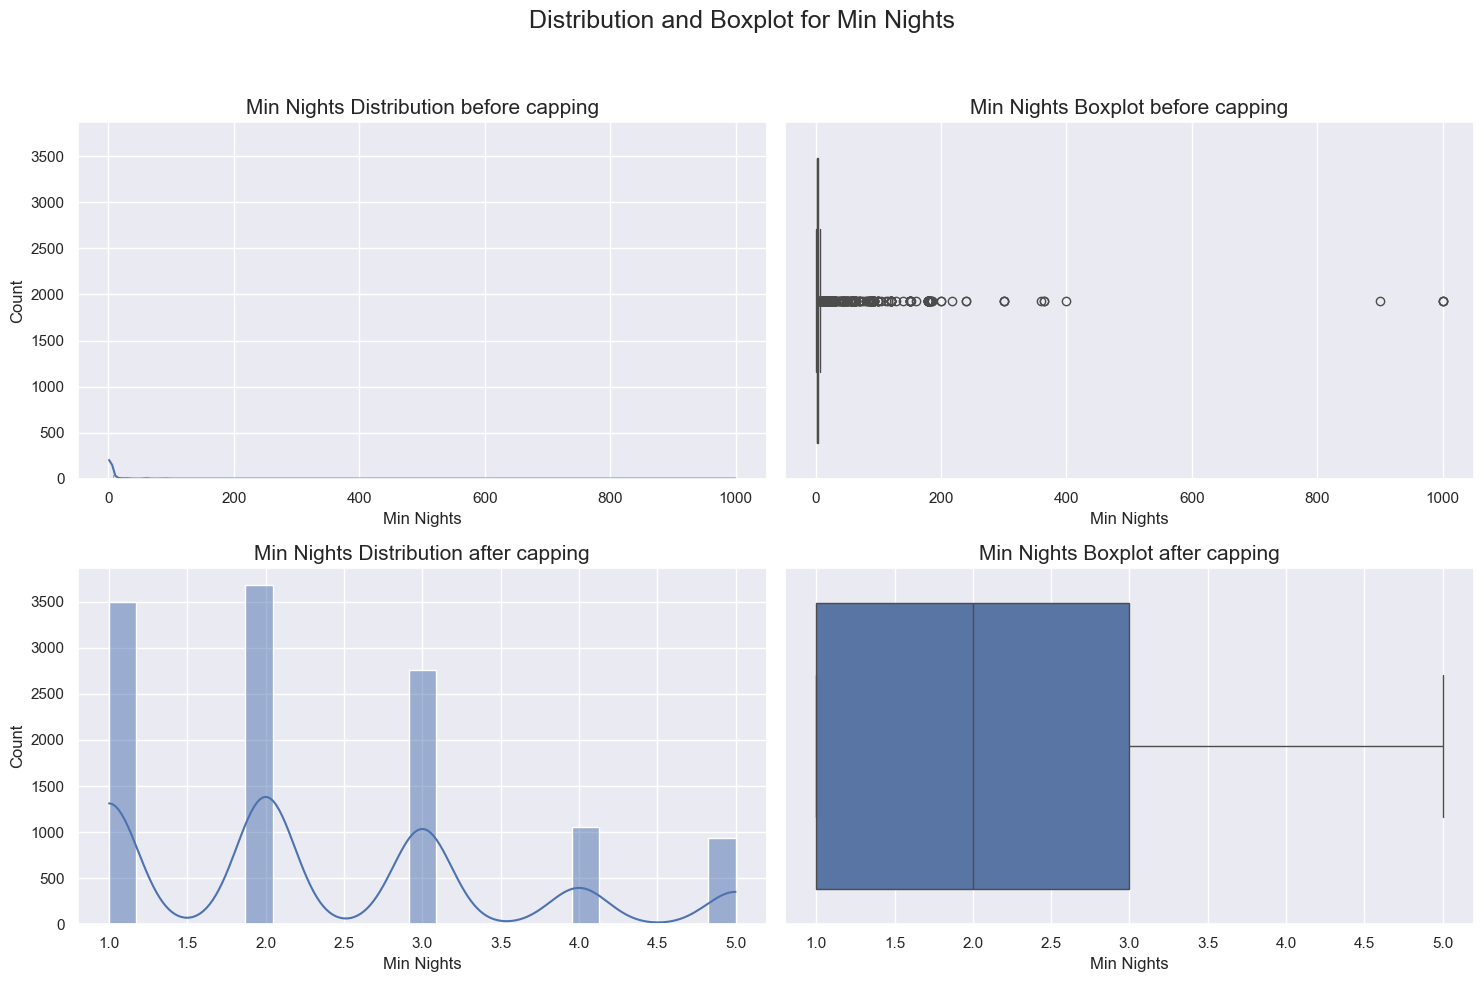

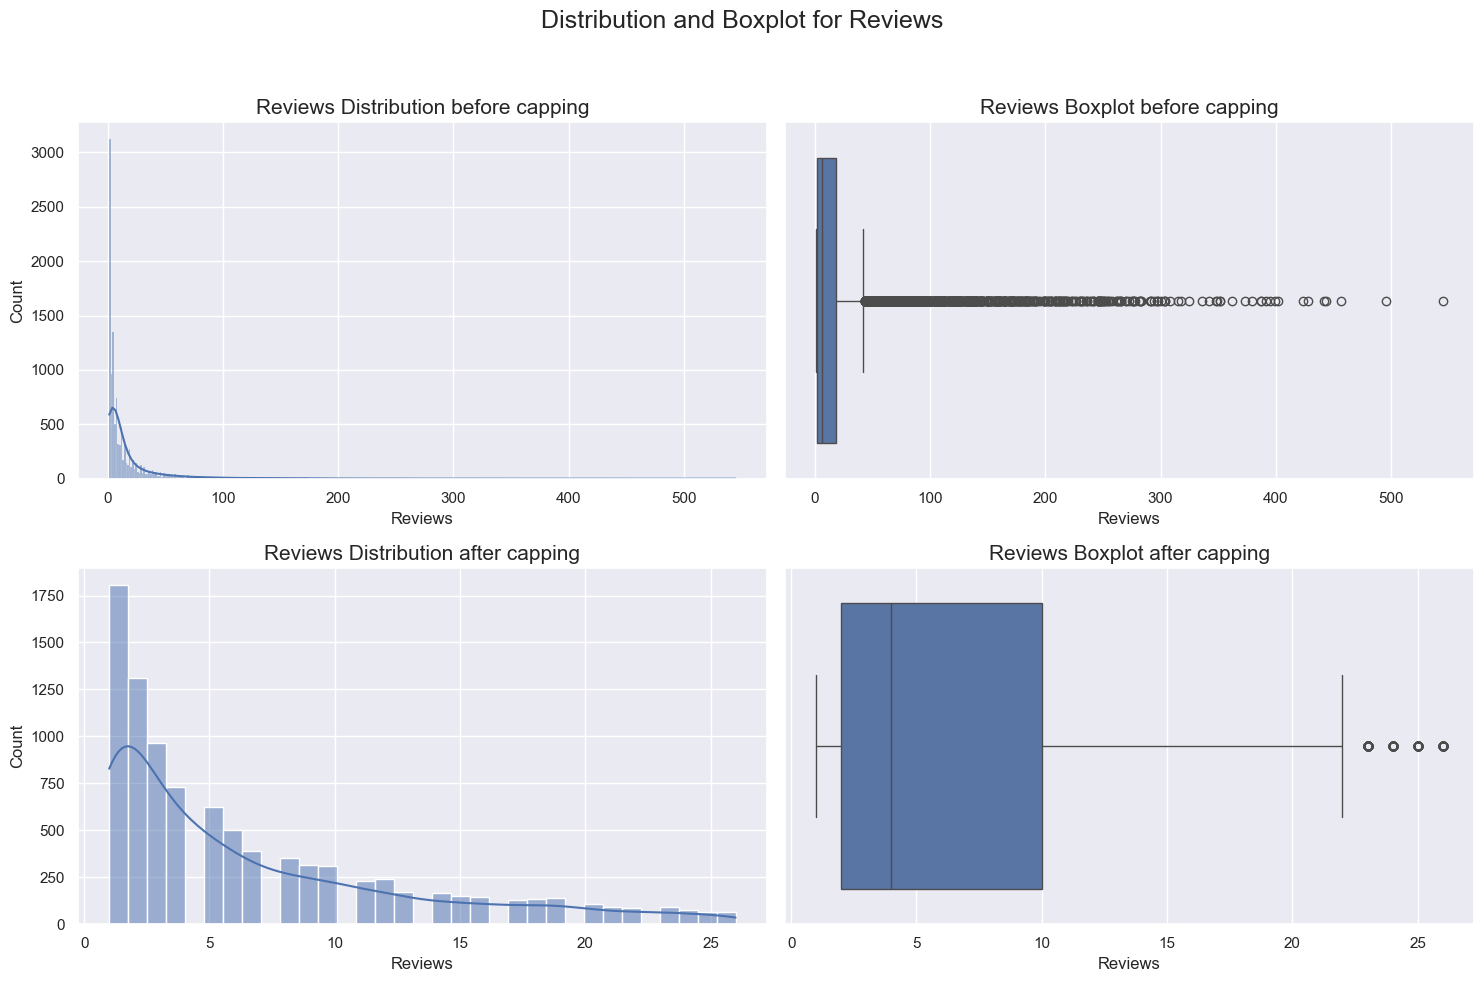

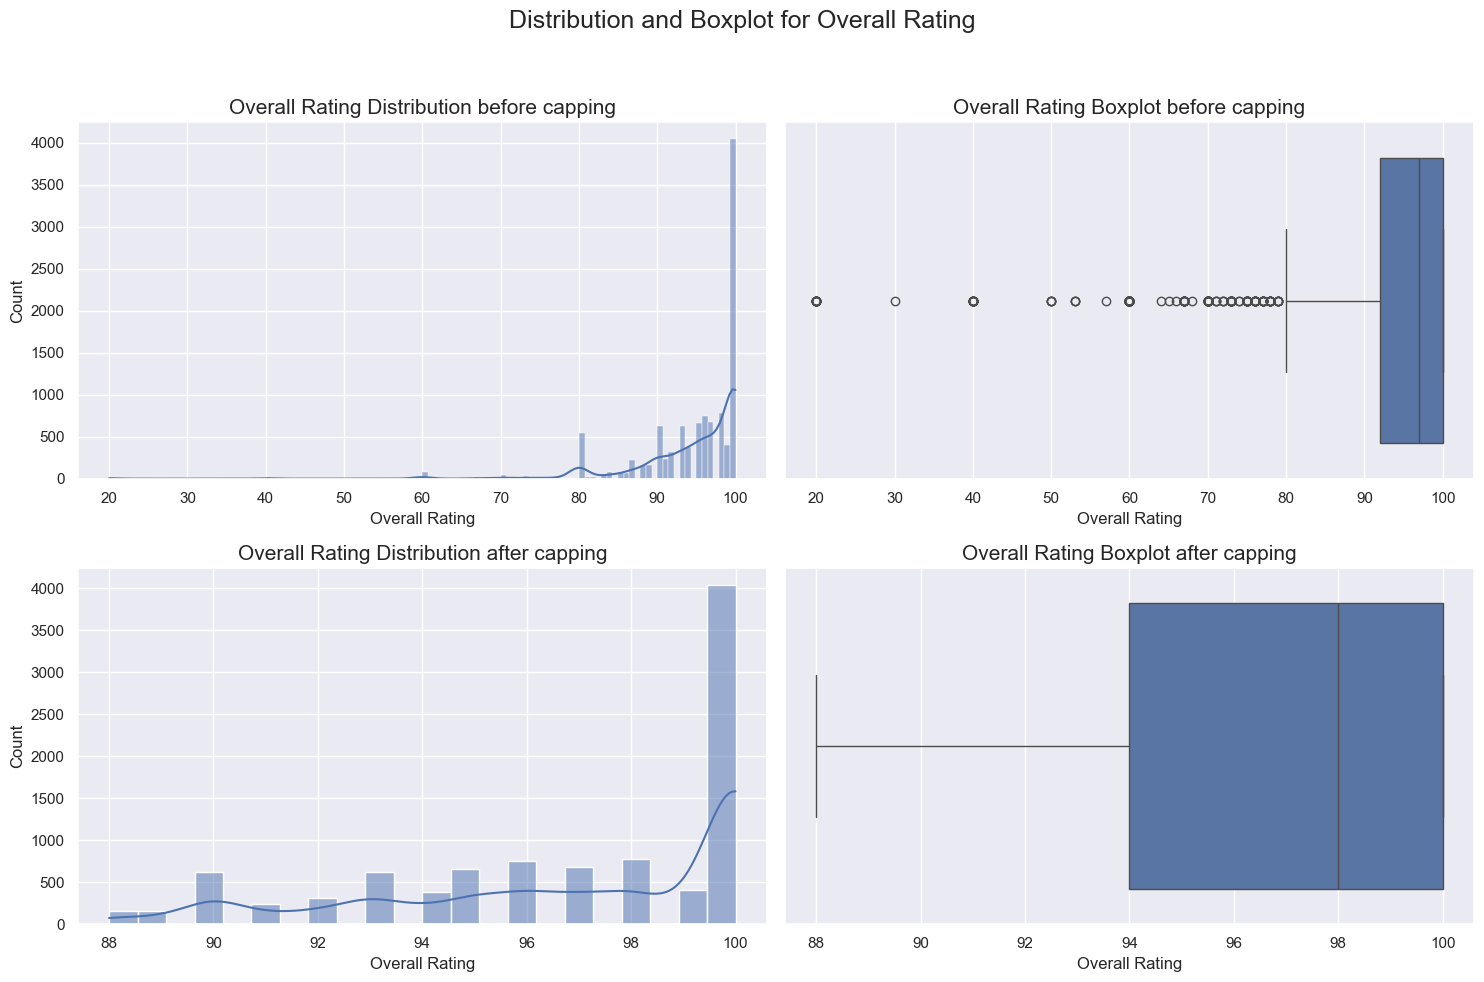

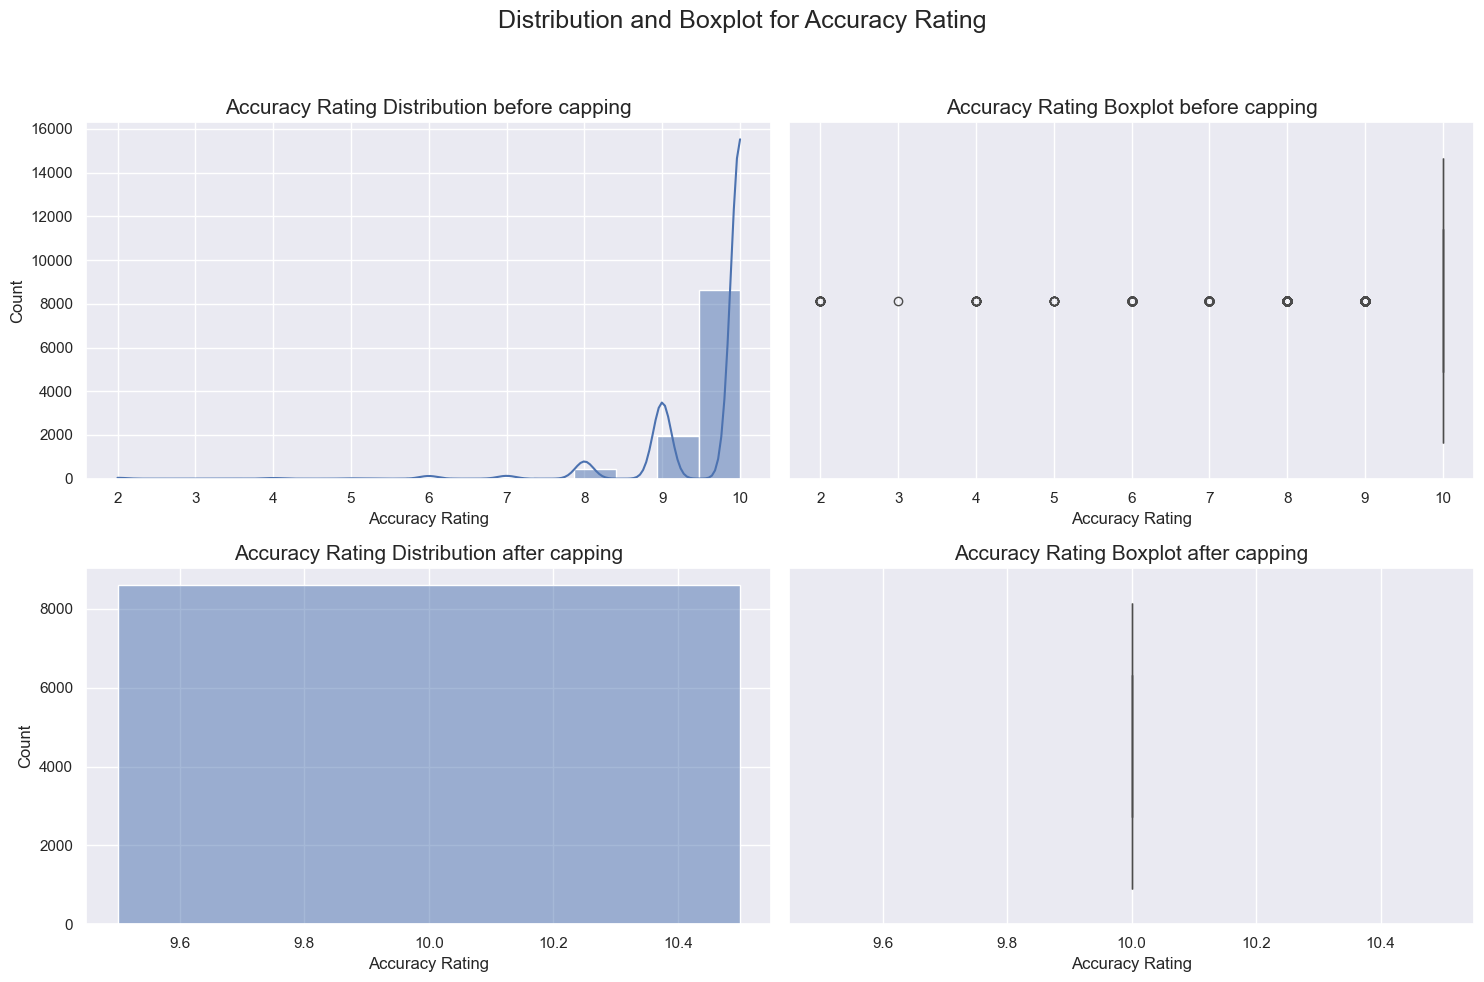

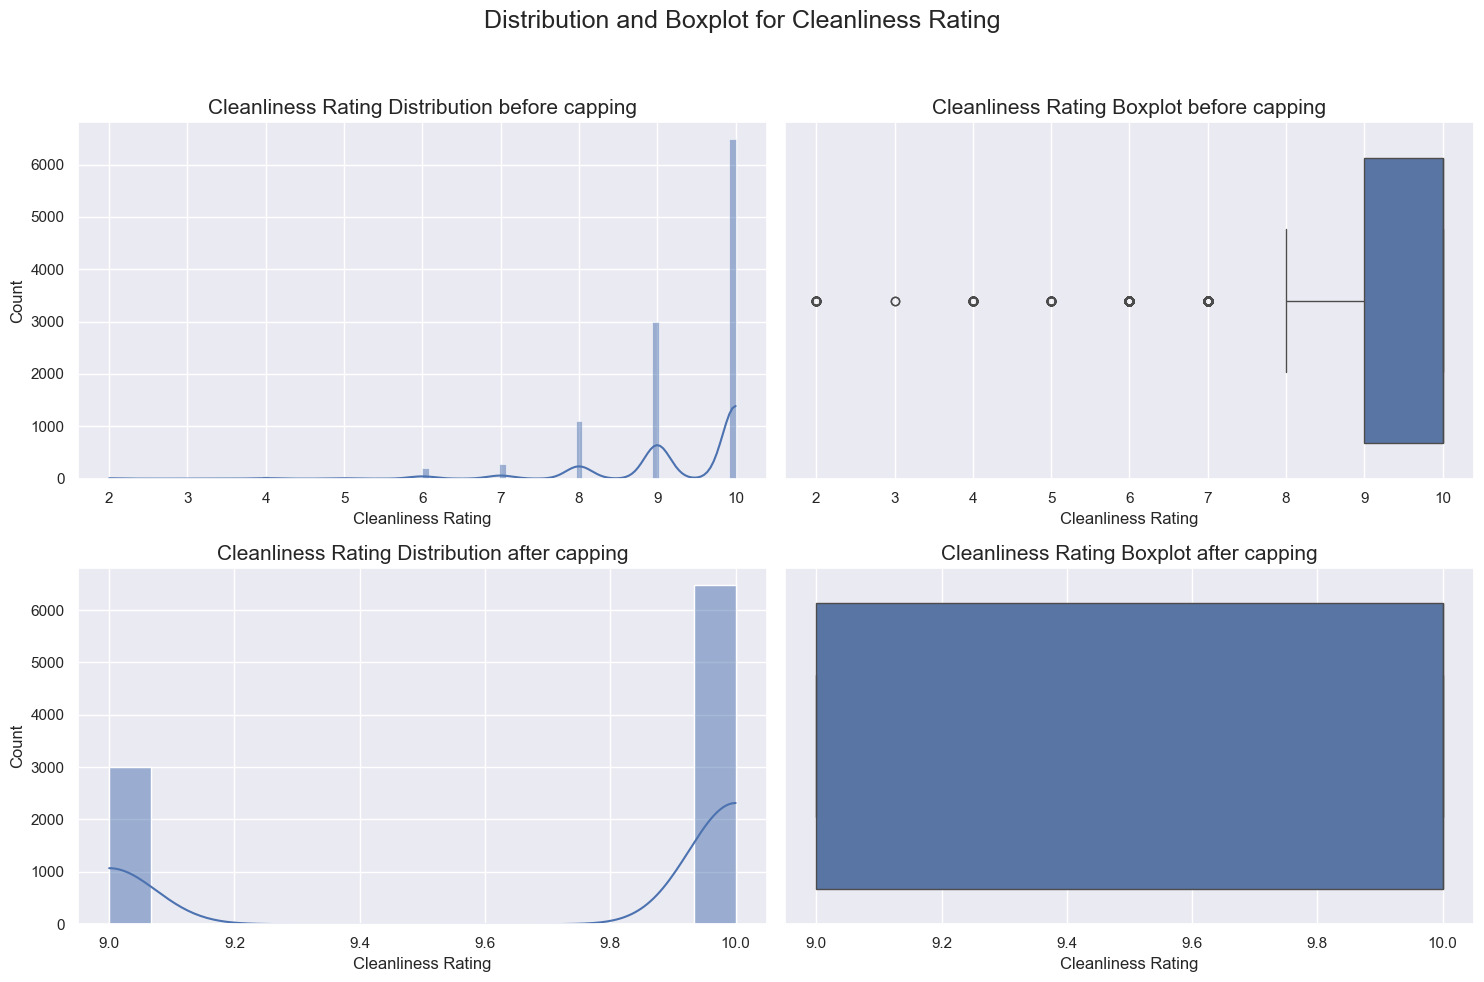

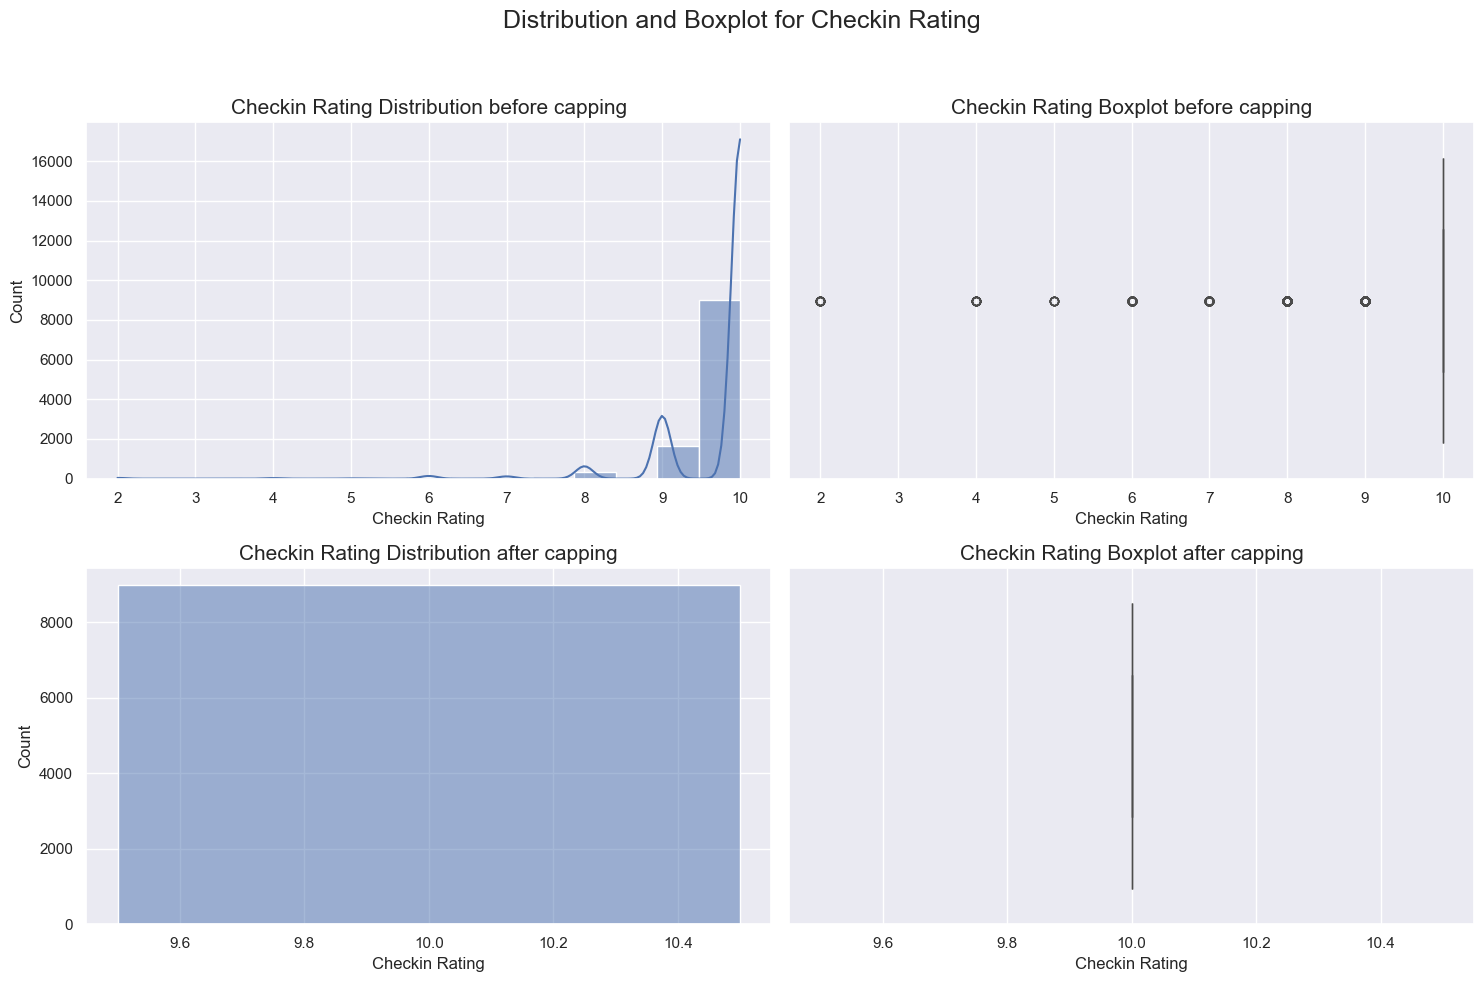

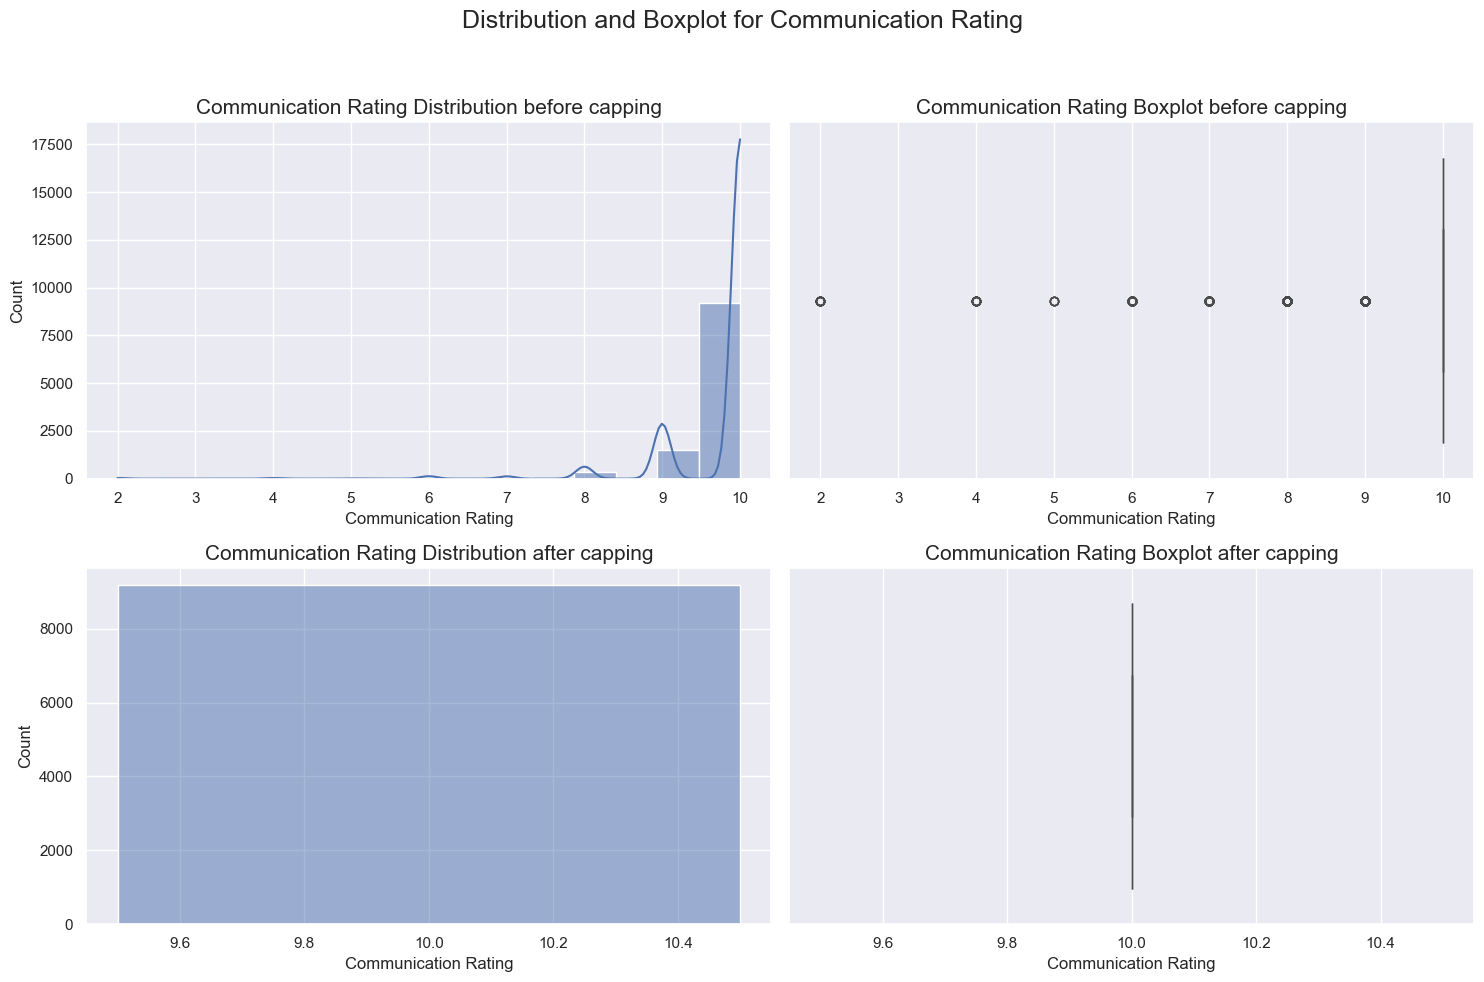

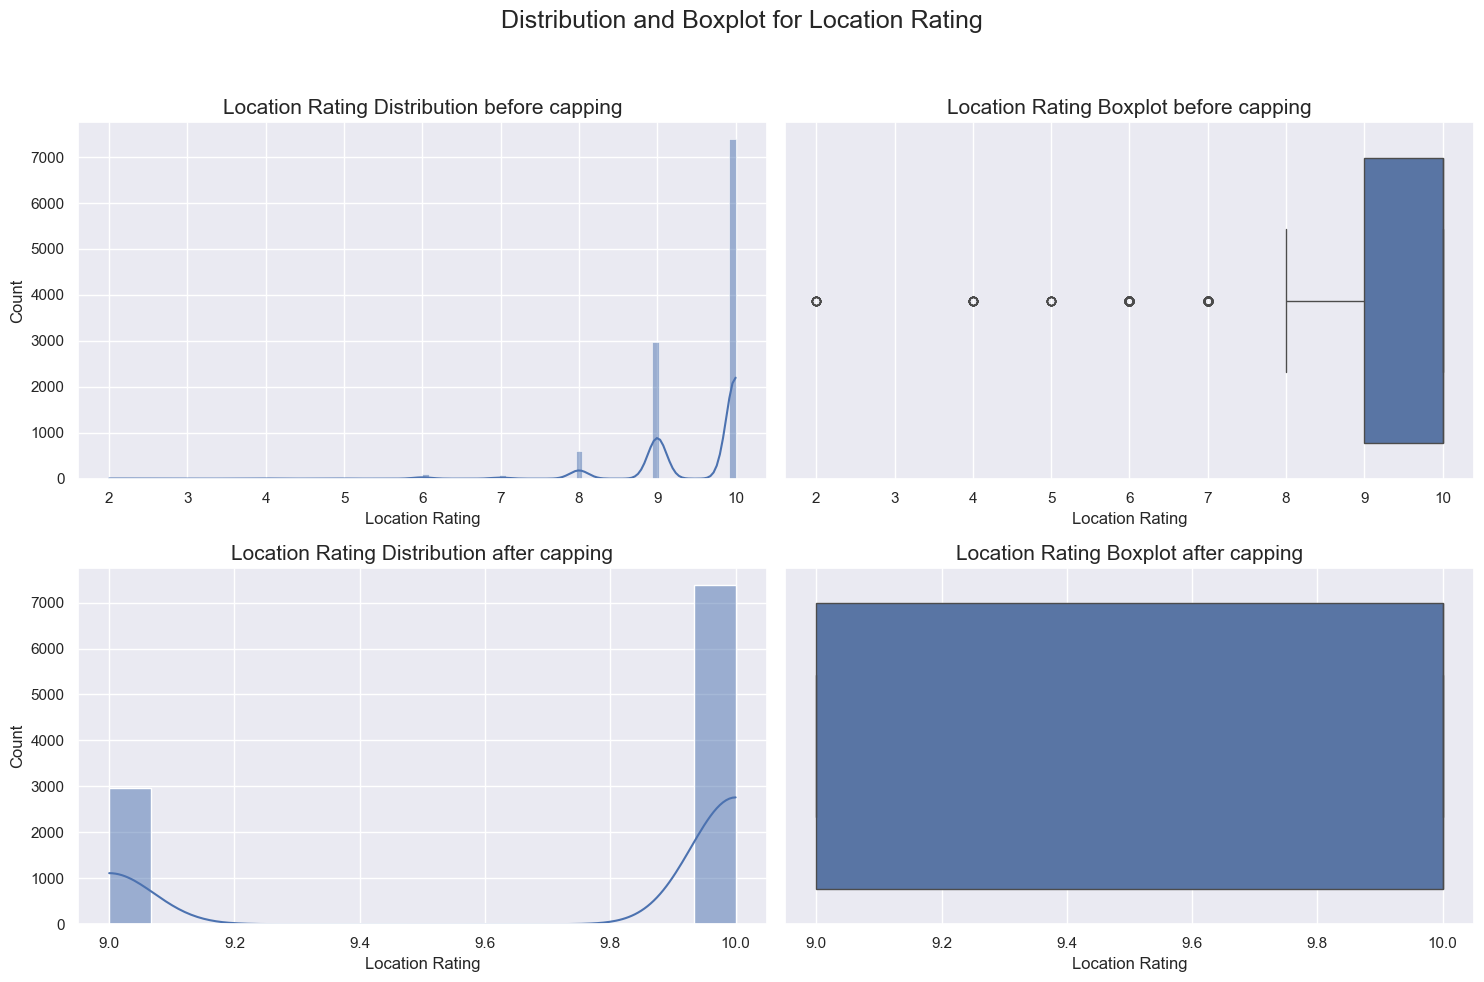

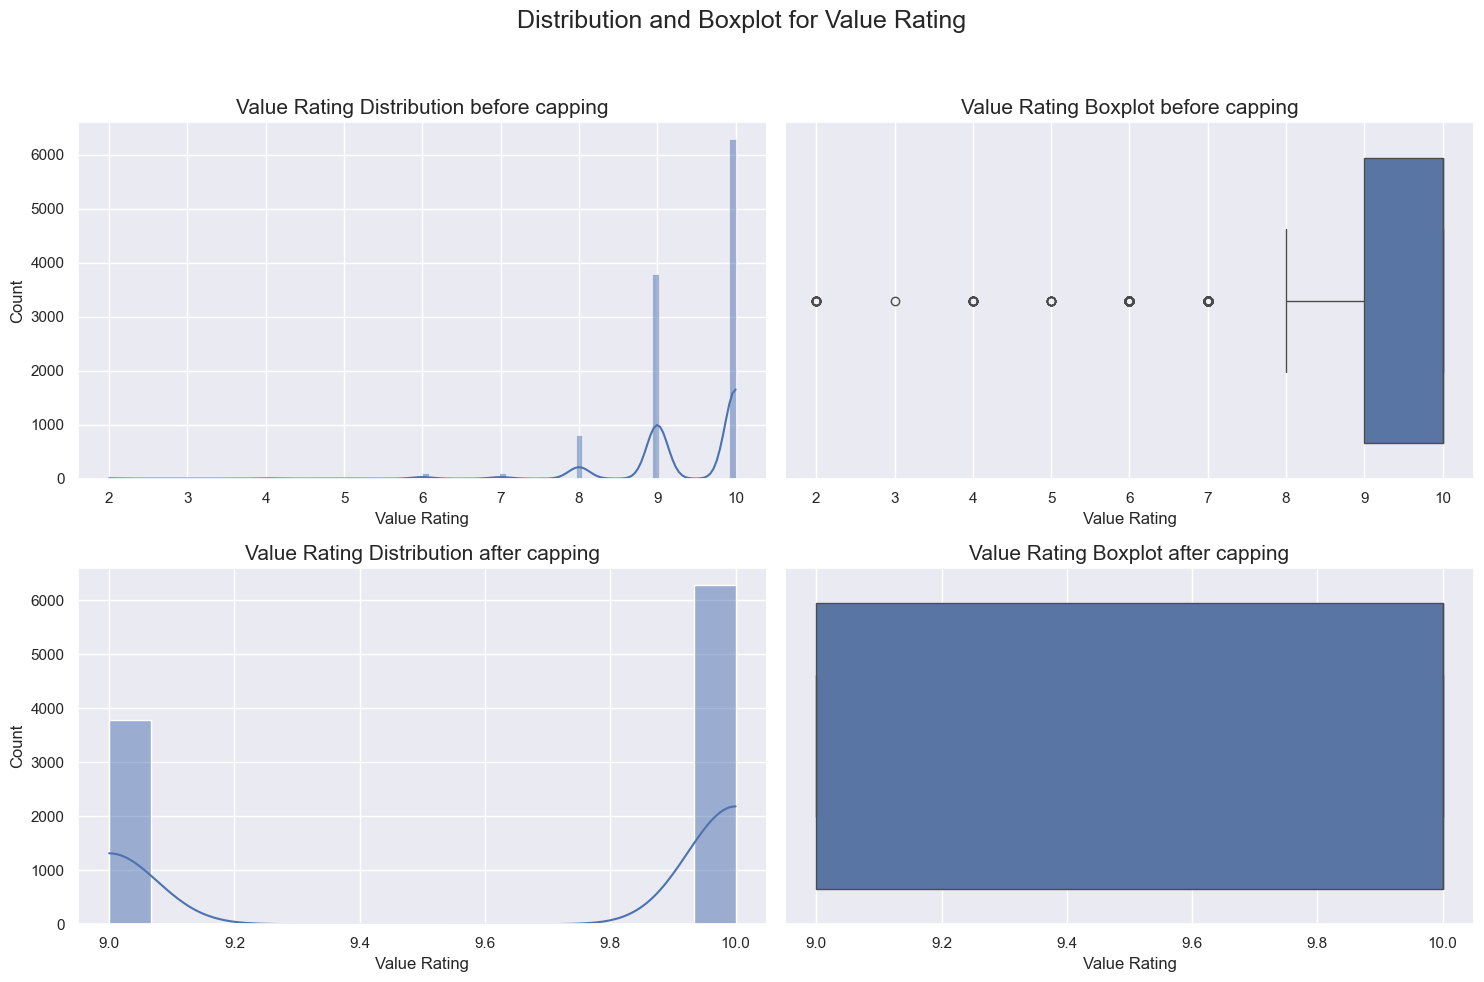

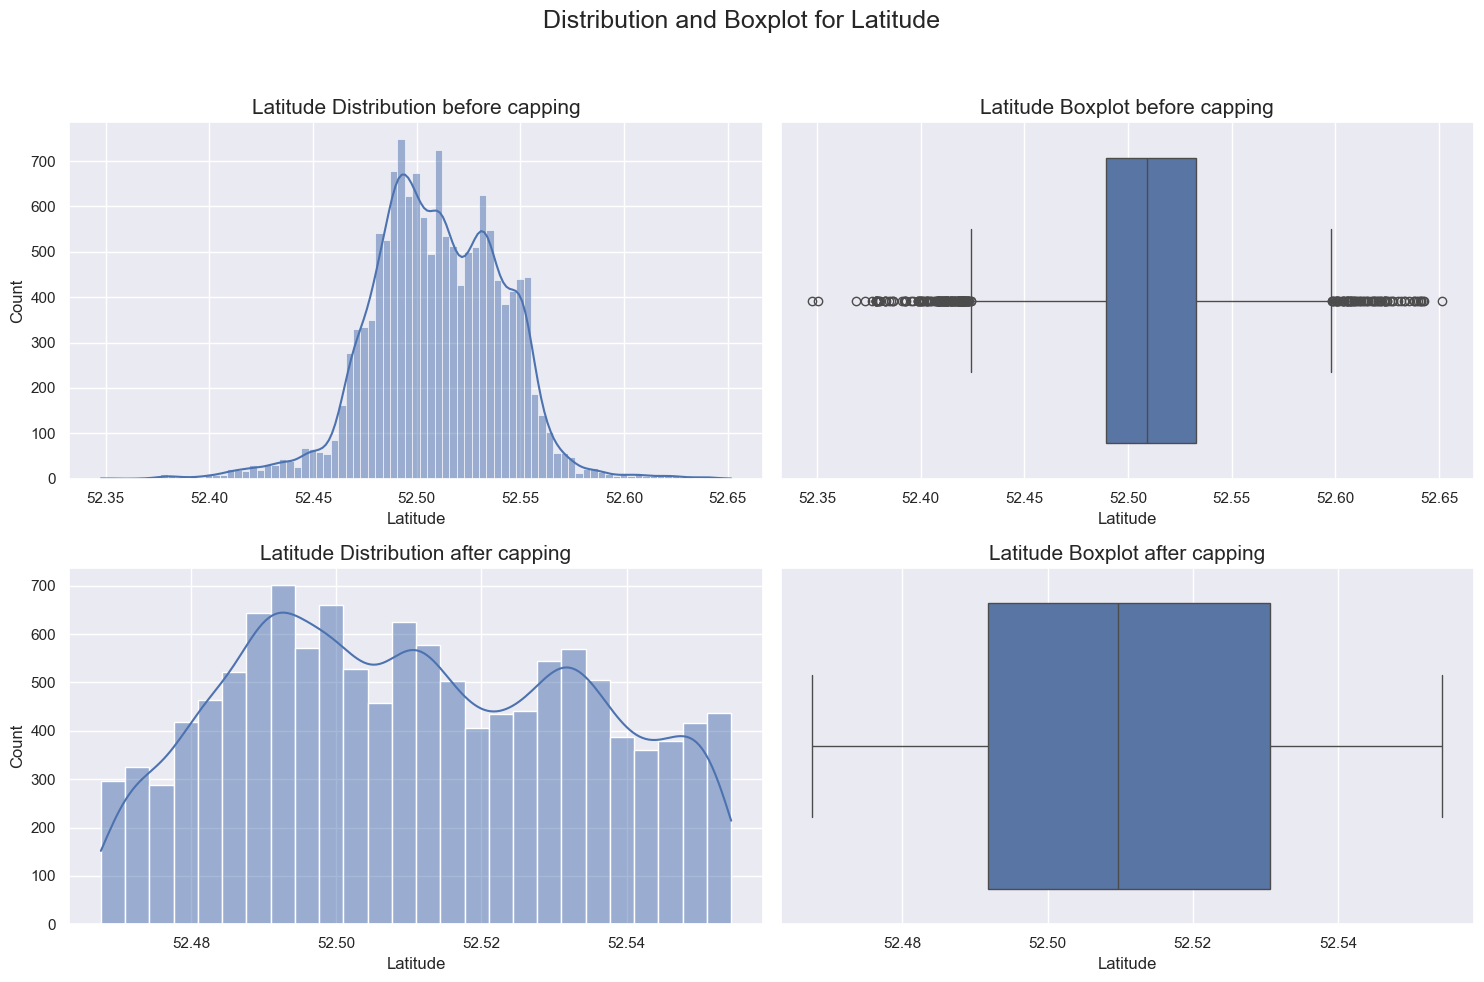

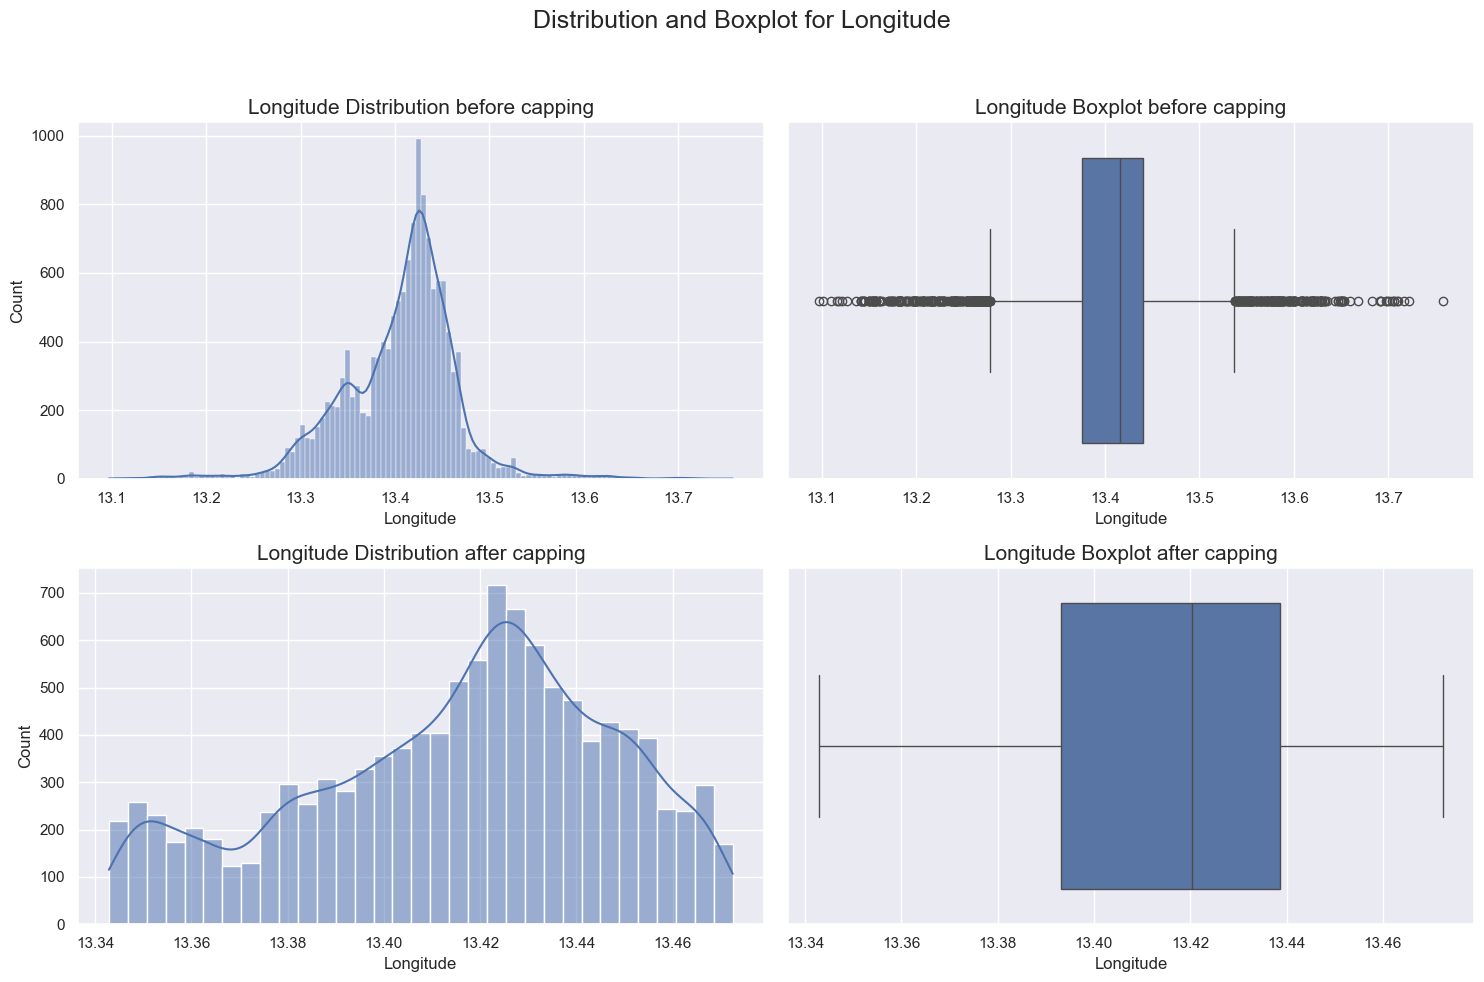

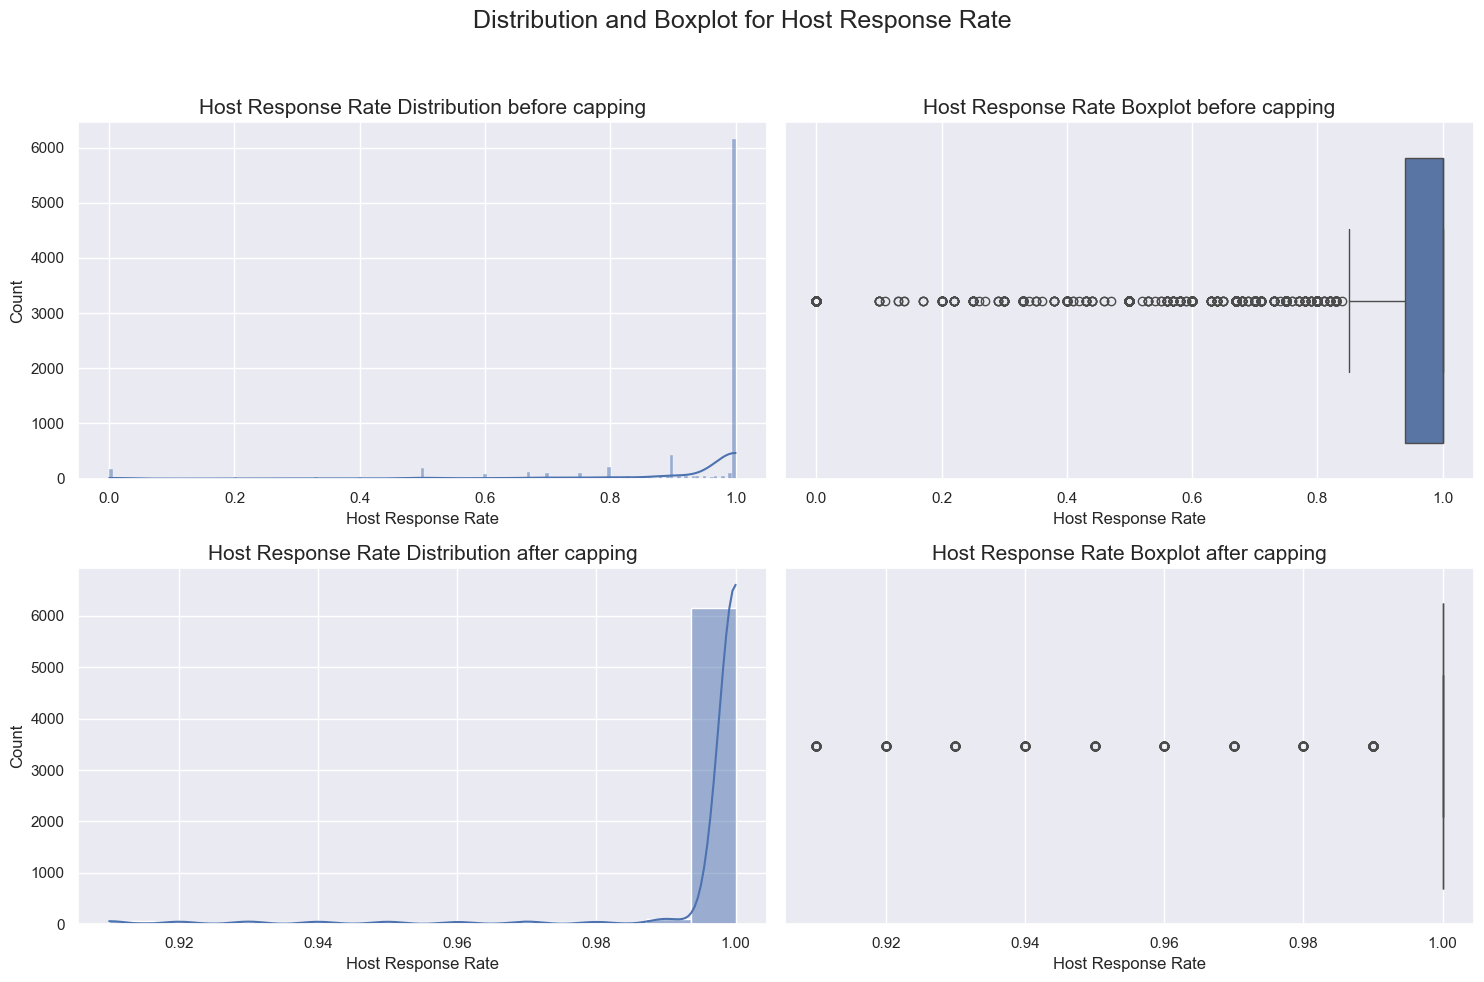

In [932]:
import matplotlib.pyplot as plt
import seaborn as sns

def dist_outliers(original_df, capped_df, cols):
    # Iterate over the specified columns
    for col in cols:
        # Set up the figure with a fixed size
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Distribution and Boxplot for {col}', fontsize=18)

        # Original distribution
        sns.histplot(original_df[col], ax=axes[0, 0], kde=True)
        axes[0, 0].set_title(f'{col} Distribution before capping', fontsize=15)

        # Original boxplot
        sns.boxplot(x=original_df[col], ax=axes[0, 1])
        axes[0, 1].set_title(f'{col} Boxplot before capping', fontsize=15)

        # Capped distribution
        sns.histplot(capped_df[col], ax=axes[1, 0], kde=True)
        axes[1, 0].set_title(f'{col} Distribution after capping', fontsize=15)

        # Capped boxplot
        sns.boxplot(x=capped_df[col], ax=axes[1, 1])
        axes[1, 1].set_title(f'{col} Boxplot after capping', fontsize=15)

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
        plt.show()


dist_outliers(df_panel,cap_df,cols)

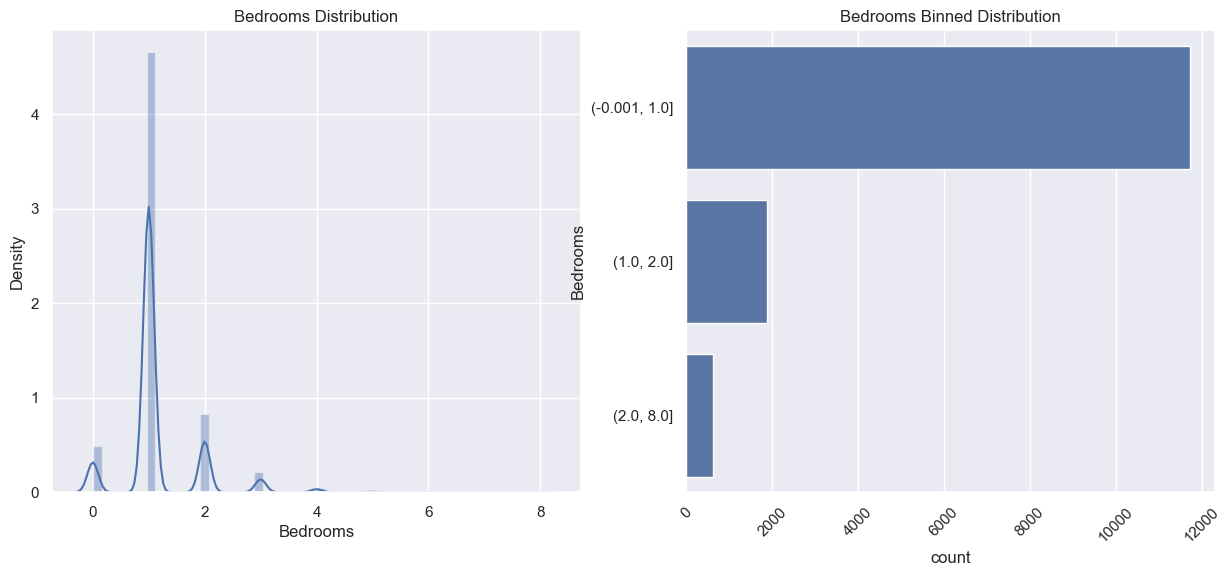

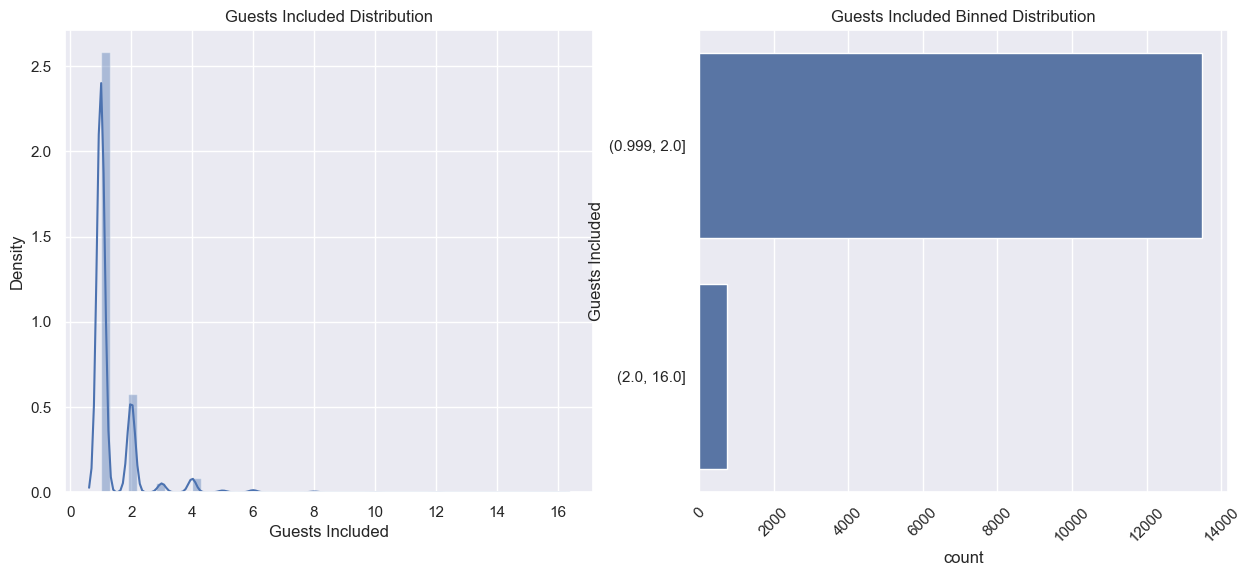

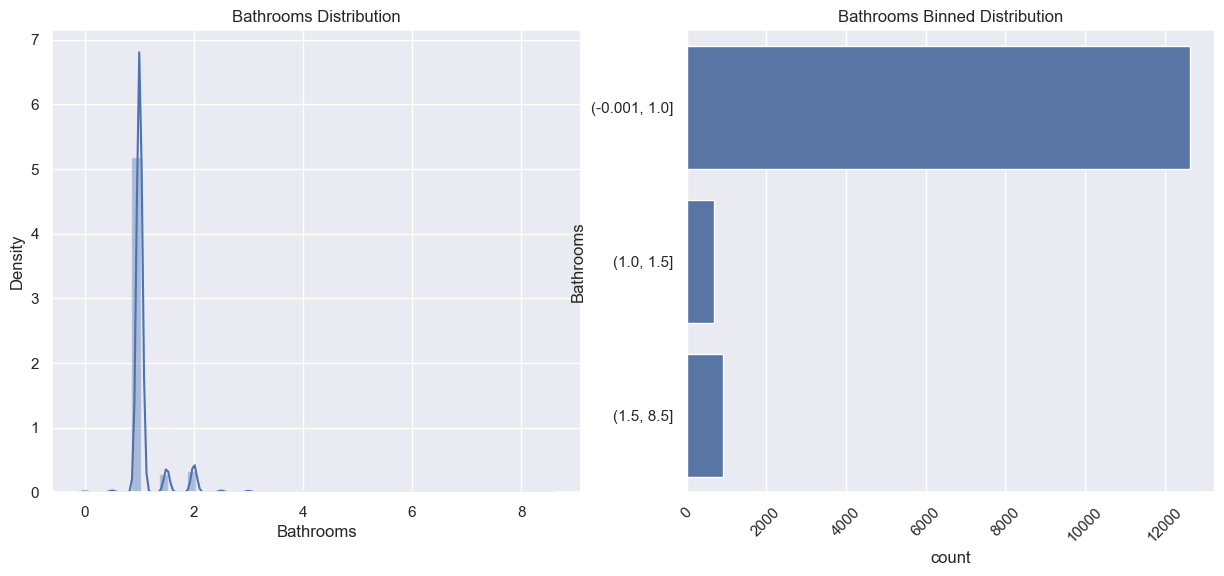

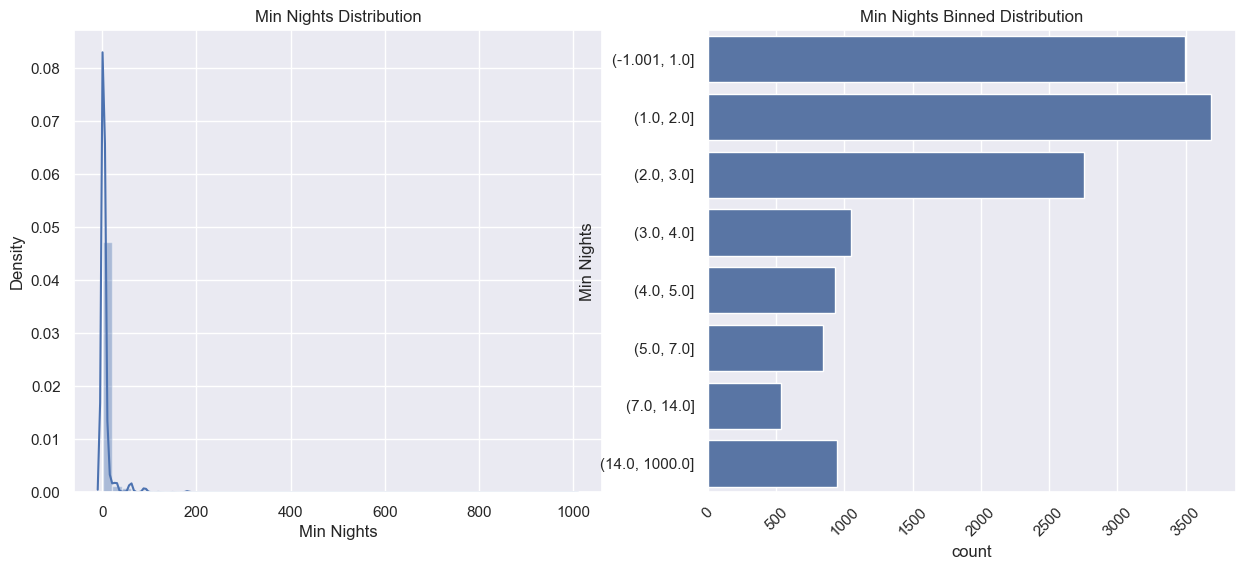

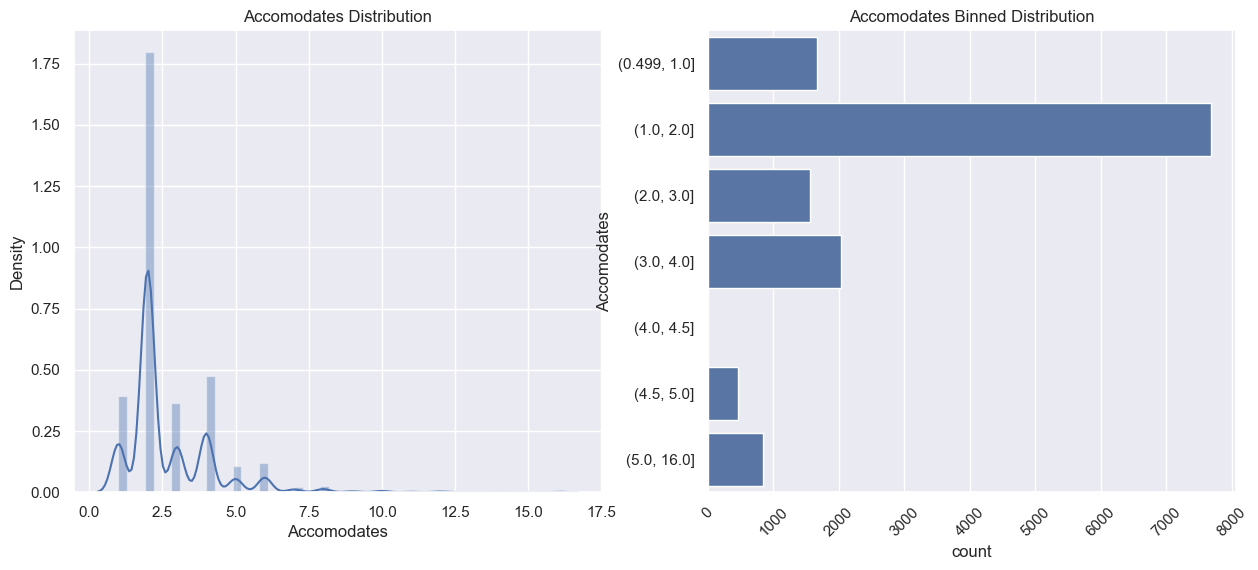

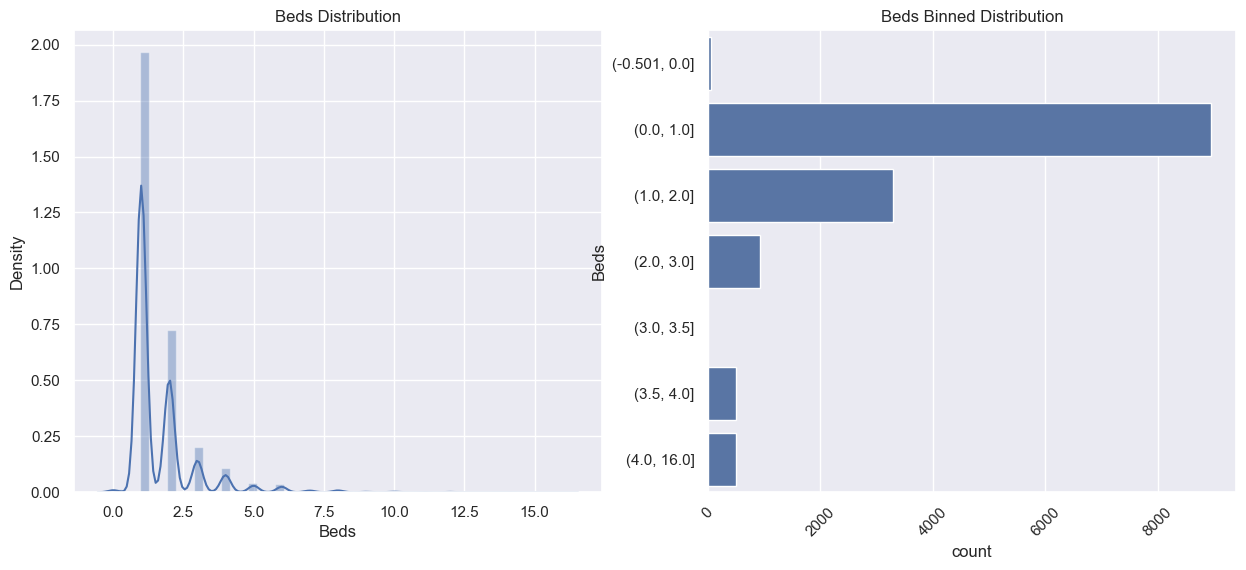

In [933]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



def bin_numerical_columns(df, cols, outlier_threshold=1.5):
    binned_columns = {}

    for col in cols:
        # Calculate the IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Determine the number of bins based on the distribution
        num_bins = int(np.ceil(np.log2(len(df[col].dropna())) + 1))

        # Define bin edges
        bins = pd.qcut(df[col], q=num_bins, duplicates='drop', retbins=True)[1]
        
        # Extend bins to include outliers
        lower_bound = Q1 - outlier_threshold * IQR
        upper_bound = Q3 + outlier_threshold * IQR
        bins = np.append(bins, [lower_bound, upper_bound])
        bins = np.unique(bins)

        # Bin the column
        binned_columns[col] = pd.cut(df[col], bins=bins, include_lowest=True)
        
        # Plot the original and binned distribution
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        sns.distplot(df[col].dropna())
        plt.title(f'{col} Distribution')
        plt.subplot(1, 2, 2)
        sns.countplot(binned_columns[col])
        plt.title(f'{col} Binned Distribution')
        plt.xticks(rotation=45)
        plt.show()

    return pd.DataFrame(binned_columns)

# Example usage
cols_bin=['Bedrooms', 'Guests Included', 'Bathrooms', 'Min Nights', 'Accomodates', 'Beds']
binned_df = bin_numerical_columns(df_panel, cols_bin)



In [934]:
#Creating a table for outliers change

#out_df

In [935]:
# Checking distribution and correlation changes
out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])
for col in numeric_cols:
    out = df_panel[col]
    non_out = df_panel[col][outliers_df[col] == 0]
    cor_out = df_panel['Price']
    cor_non_out = df_panel['Price'][outliers_df[col] == 0]
    
    # Filter out NaN values for correlation calculation
    valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
    valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)
    
    if valid_out.sum() > 1 and valid_non_out.sum() > 1:
        cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] - 
                                np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
    else:
        cor_change = '-'

    dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

    new_row = pd.DataFrame({'feature': [col],
                            'outliers_cnt': [outliers_df[col].sum()],
                            'distribution_changed': [dist_change],
                            'correlation_changed': [cor_change]})

    out_df = pd.concat([out_df, new_row], ignore_index=True)
    # Filter features where only distribution changes but not correlation
out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,Accomodates,1307,+,+,no
1,Bathrooms,1680,+,-,yes
2,Bedrooms,3628,+,-,yes
3,Beds,997,+,-,yes
4,Guests Included,3216,+,-,yes
5,Min Nights,1480,+,-,yes
6,Reviews,1339,+,-,yes
7,Overall Rating,295,+,-,yes
8,Accuracy Rating,2557,+,-,yes
9,Cleanliness Rating,599,+,-,yes


### Outlier Handling Strategy

I chose not to remove the ratings columns, as ratings should be treated like categories, with all values between 1-10 being valid.

For the columns `Accommodates`, `Bathrooms`, `Bedrooms`, `Beds`, `Guests Included`, and `Min Nights`, I opted to create new columns with bins. This approach reduces the impact of outliers by grouping extreme values together, (see in the feature engineering part).

For the `Longitude` column, I decided not to remove outliers to avoid losing information on listings in distant locations, which could influence the price.

For the `Reviews` column, I chose to remove outliers and cap the values at the upper boundary.



In [936]:
to_drop = ['Reviews']

In [937]:
# Remove outliers
df_cleaned = df_panel.copy()
for col in to_drop:
    df_cleaned.loc[outliers_df[col] == 1, col] = np.nan

In [938]:
# Save cleaned data
df_cleaned.to_pickle('df_cleaned.pkl')

# Missing Values 

In [939]:
df_nulls = df_panel.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls

,Listing Name,Host Name,Host Since,Host Response Time,Host Response Rate,City,Bathrooms,Bedrooms,Beds,Reviews,...,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Is Superhost_ind,Postal Code_n
65536,Central apartment near Alex (Apt. 9),Sven,2016-06-29,within a few hours,1.0,Berlin,1.0,2.0,4.0,118.0,...,2019-05-10,95.0,10.0,10.0,10.0,10.0,10.0,9.0,1,10179
65603,"SchÃ¶ne, helle Whg nahe Tempelh. Feld in NeukÃ...",Renald,2016-06-29,<NA>,NaN,Berlin,1.0,1.0,2.0,22.0,...,2018-02-18,96.0,10.0,9.0,10.0,10.0,9.0,10.0,0,12051
65625,Cozy and quiet Loft in Central Berlin,Sonja,2016-06-27,<NA>,NaN,Berlin,1.0,1.0,1.0,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10119
65626,"Cozy room in Berlin, Charlottenburg!",Eva,2016-03-12,<NA>,NaN,Berlin,1.0,1.0,1.0,1.0,...,2016-07-17,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,10589
65627,Small but nice and quite room,Janka,2015-11-27,<NA>,NaN,Berlin,1.0,1.0,1.0,7.0,...,2016-10-11,97.0,9.0,10.0,10.0,10.0,10.0,10.0,0,10407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456582,"Chillout-Oase fÃ¼r ""GroÃ und Klein""",Luca,2015-09-22,<NA>,NaN,Berlin,1.0,2.0,2.0,3.0,...,2016-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,<NA>
456585,GemÃ¼tliches Zimmer zur Ãbernachtung,Anh,2015-08-06,<NA>,NaN,Berlin,1.0,1.0,1.0,20.0,...,2016-09-18,92.0,10.0,10.0,10.0,9.0,9.0,9.0,0,<NA>
456605,Potsdamer Platz-Top Spot Studio 1,Martin,2014-10-08,within an hour,1.0,Berlin,1.0,1.0,3.0,349.0,...,2019-04-28,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,<NA>
456954,Familyhome for your vacation,Simone,2013-03-17,<NA>,NaN,Berlin,1.5,4.0,6.0,4.0,...,2015-08-29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,<NA>


<Axes: >

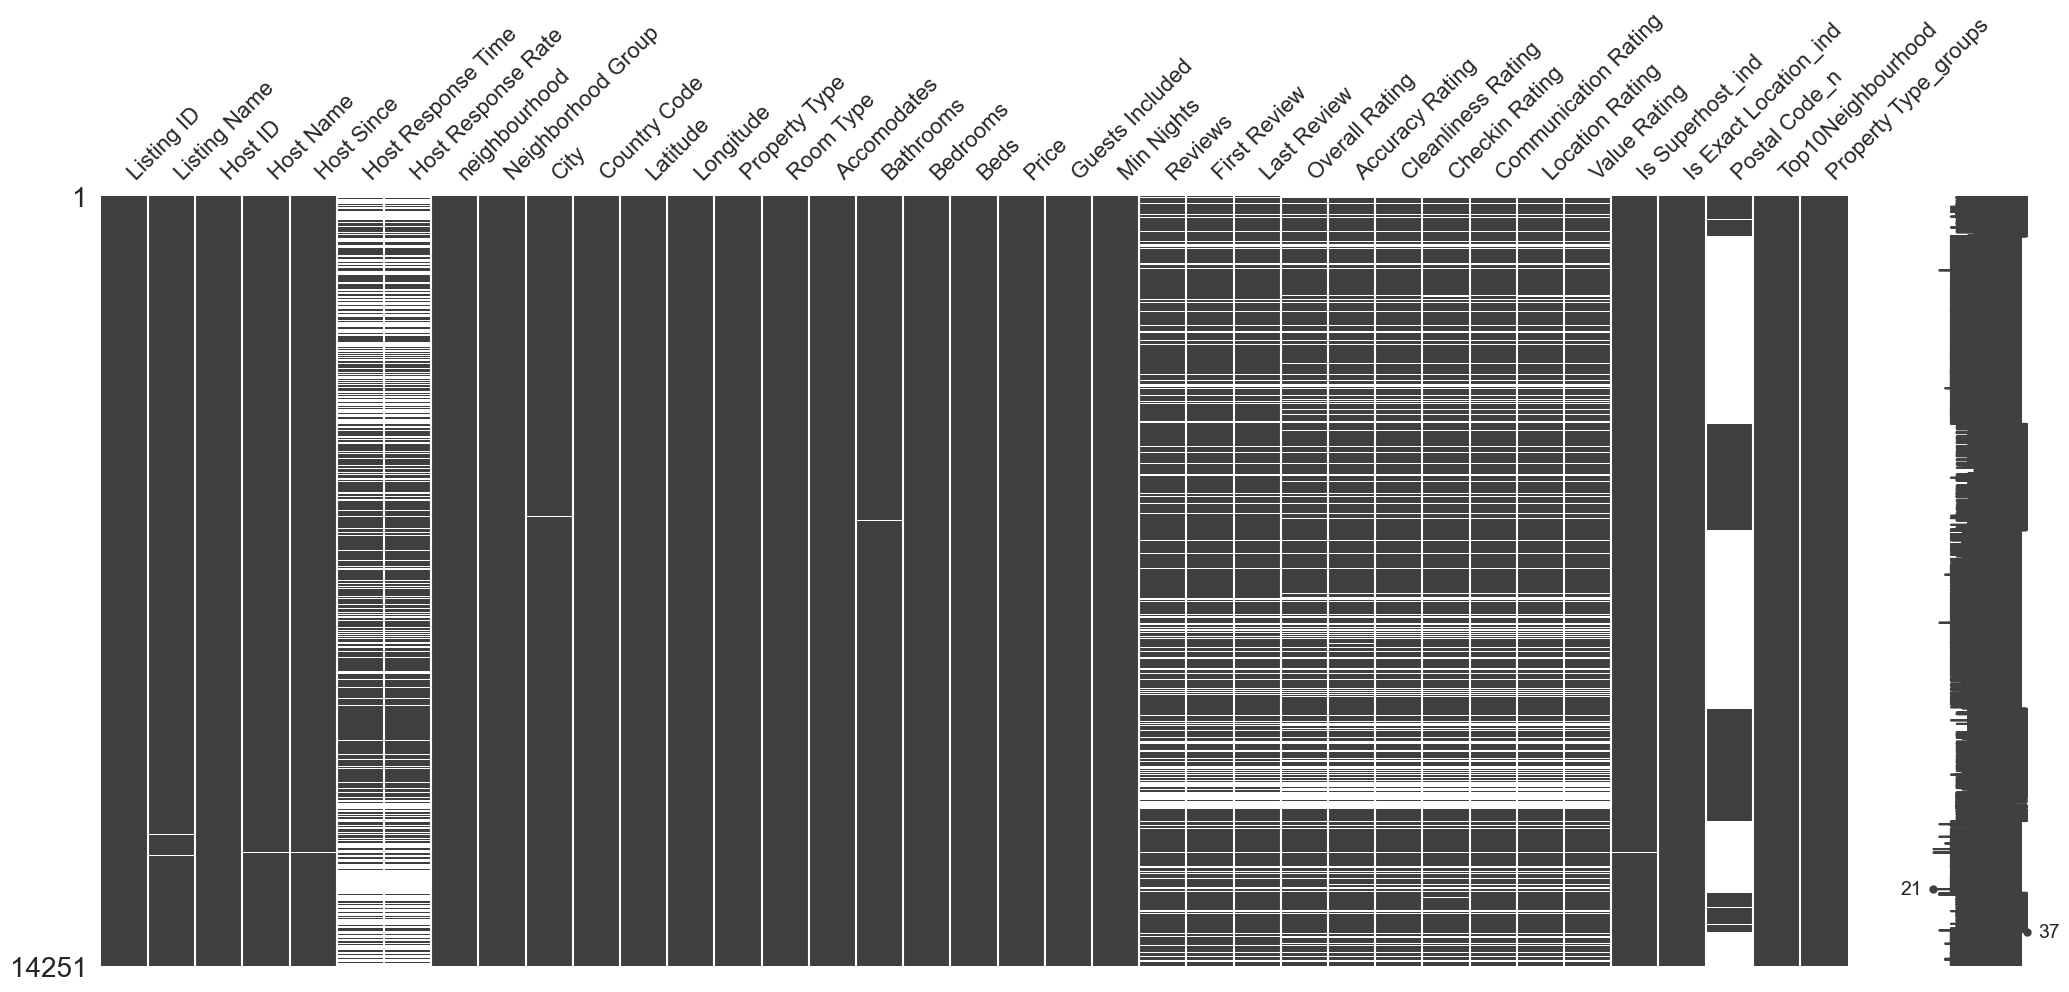

In [940]:

msno.matrix(df_panel)

<Axes: >

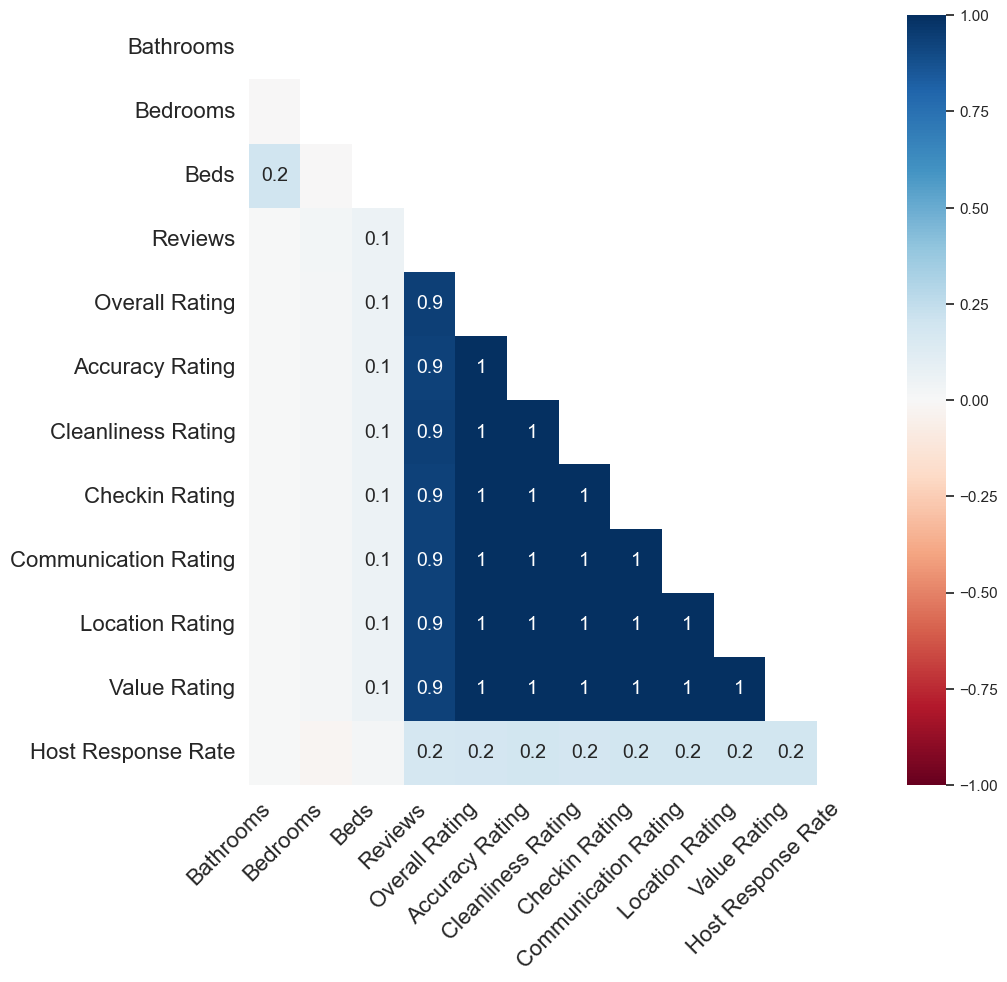

In [941]:

df_num_na=numerical_df.isna()
df_num_na
msno.heatmap(numerical_df,figsize=(10,10))

In [942]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

,Missing Values,% of Total Values
Postal Code_n,8838,62.0
Host Response Time,5653,39.7
Host Response Rate,5653,39.7
Checkin Rating,3091,21.7
Value Rating,3090,21.7
Location Rating,3088,21.7
Communication Rating,3081,21.6
Accuracy Rating,3081,21.6
Cleanliness Rating,3077,21.6
Overall Rating,3067,21.5


In [943]:

#dates columns i will deal later
#df_nulls[['Host Since', 'Last Review' , 'First Review']]

categorical_columns = df_nulls.select_dtypes(include=['string']).columns
print(categorical_columns)
categorical_columns = df_nulls.select_dtypes(include=['string']).columns

Index(['Listing Name', 'Host Name', 'Host Response Time', 'City'], dtype='object')


In [944]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

def analyze_missing_values(df, target_col):
    # Filter for numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64'])

    # Create DataFrame to store results
    MV_df_final = pd.DataFrame(columns=['Var', 'MV_pct', 'distribution_changed', 'drop', 'MV_type'])

    # Loop through numerical columns
    for col in numerical_cols:
        # Separate data with and without missing values
        null_values = df[col]
        non_null_values = df[col][df[target_col].notna()]

        # Calculate missing value percentage
        mv_pct = df[col].isna().sum()

        # Perform Kolmogorov-Smirnov test
        pval = ks_2samp(null_values.dropna(), non_null_values)[1]
        distribution_changed = '+' if pval < 0.5 else '-'

        # Create a new row as a DataFrame
        new_row = pd.DataFrame({
            'Var': [col],
            'MV_pct': [mv_pct],
            'distribution_changed': [distribution_changed],
            'drop': ['No' if distribution_changed == '+' else 'Yes'],
            'MV_type': ['MNAR' if distribution_changed == '+' else 'MCAR/MAR']
        })

        # Concatenate the new row to the result DataFrame
        MV_df_final = pd.concat([MV_df_final, new_row], ignore_index=True)

    # Filter and sort the DataFrame
    MV_df_final = MV_df_final[MV_df_final['MV_pct'] > 0].sort_values(by='MV_pct', ascending=False)
    
    return MV_df_final

# Example usage:
MV_df_final = analyze_missing_values(df_cleaned, 'Price')
MV_df_final


,Var,MV_pct,distribution_changed,drop,MV_type
22,Postal Code_n,8838,-,Yes,MCAR/MAR
2,Host Response Rate,5653,-,Yes,MCAR/MAR
12,Reviews,4123,-,Yes,MCAR/MAR
16,Checkin Rating,3091,-,Yes,MCAR/MAR
19,Value Rating,3090,-,Yes,MCAR/MAR
18,Location Rating,3088,-,Yes,MCAR/MAR
14,Accuracy Rating,3081,-,Yes,MCAR/MAR
17,Communication Rating,3081,-,Yes,MCAR/MAR
15,Cleanliness Rating,3077,-,Yes,MCAR/MAR
13,Overall Rating,3067,-,Yes,MCAR/MAR


In [945]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14251 entries, 65536 to 456958
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Listing ID             14251 non-null  int64         
 1   Listing Name           14226 non-null  string        
 2   Host ID                14251 non-null  int64         
 3   Host Name              14238 non-null  string        
 4   Host Since             14238 non-null  datetime64[ns]
 5   Host Response Time     8598 non-null   string        
 6   Host Response Rate     8598 non-null   float64       
 7   neighbourhood          14251 non-null  string        
 8   Neighborhood Group     14251 non-null  string        
 9   City                   14248 non-null  string        
 10  Country Code           14251 non-null  string        
 11  Latitude               14251 non-null  float64       
 12  Longitude              14251 non-null  float64       
 13  P

In [946]:
from sklearn.impute import KNNImputer
import pandas as pd

# Create a copy of the cleaned DataFrame
not_missing_df = df_cleaned.copy()



In [947]:
def handle_missing_ratings(df, rating_columns):
    for col in rating_columns:
        # Fill missing values with -2
        df[col].fillna(-2, inplace=True)
        # Create an indicator column
        indicator_col = f'{col}_missing'
        df[indicator_col] = df[col].apply(lambda x: 1 if x == -2 else 0)
    return df

# Example usage
rating_columns = ['Host Response Rate', 'Checkin Rating', 'Value Rating', 
                  'Location Rating', 'Accuracy Rating', 
                  'Communication Rating', 'Cleanliness Rating', 
                  'Overall Rating']

not_missing_df = handle_missing_ratings(not_missing_df, rating_columns)

In [948]:
def fill_missing_with_zero(df, columns):
    for col in columns:
        df[col].fillna(0, inplace=True)
    return df

# Columns to fill missing values with 0
columns_to_fill = ['Is Superhost_ind', 'Reviews']

# Example usage
not_missing_df = fill_missing_with_zero(df_cleaned, columns_to_fill)

In [949]:
# Drop the specified column
if 'Postal Code_n' in not_missing_df.columns:
    not_missing_df = not_missing_df.drop(columns=['Postal Code_n'])

In [950]:
not_missing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14251 entries, 65536 to 456958
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Listing ID             14251 non-null  int64         
 1   Listing Name           14226 non-null  string        
 2   Host ID                14251 non-null  int64         
 3   Host Name              14238 non-null  string        
 4   Host Since             14238 non-null  datetime64[ns]
 5   Host Response Time     8598 non-null   string        
 6   Host Response Rate     8598 non-null   float64       
 7   neighbourhood          14251 non-null  string        
 8   Neighborhood Group     14251 non-null  string        
 9   City                   14248 non-null  string        
 10  Country Code           14251 non-null  string        
 11  Latitude               14251 non-null  float64       
 12  Longitude              14251 non-null  float64       
 13  P

In [951]:
imputed_data

,Listing ID,Host ID,Host Response Rate,Latitude,Longitude,Accomodates,Bathrooms,Bedrooms,Beds,Price,...,Is Superhost_ind,Is Exact Location_ind,Host Response Rate_missing,Checkin Rating_missing,Value Rating_missing,Location Rating_missing,Accuracy Rating_missing,Communication Rating_missing,Cleanliness Rating_missing,Overall Rating_missing
0,13761071.0,80675177.0,1.0,52.50920,13.41762,6.0,1.0,2.0,4.0,109.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13763834.0,80714211.0,-2.0,52.46713,13.42733,2.0,1.0,1.0,2.0,50.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13764102.0,80179711.0,-2.0,52.53294,13.40649,2.0,1.0,1.0,1.0,69.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,13764166.0,62639492.0,-2.0,52.52670,13.30916,2.0,1.0,1.0,1.0,30.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13765505.0,49985648.0,-2.0,52.53924,13.43521,1.0,1.0,1.0,1.0,25.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14246,9991497.0,44816934.0,-2.0,52.45494,13.51423,6.0,1.0,2.0,2.0,50.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14247,9993168.0,40660291.0,-2.0,52.50099,13.49185,2.0,1.0,1.0,1.0,20.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14248,9994644.0,22276081.0,1.0,52.50283,13.37799,4.0,1.0,1.0,3.0,60.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14249,999465.0,5494219.0,-2.0,52.51001,13.45366,9.0,1.5,4.0,6.0,150.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [952]:

# Select columns with numeric data types
#['Beds','Bathrooms','Bedrooms']

imp_cols=not_missing_df.select_dtypes(include=['float64','int64']).columns

# Check if imp_cols has any columns
if imp_cols.empty:
    raise ValueError("No numeric columns found for imputation.")

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=1)

# Ensure that the DataFrame contains numerical columns only
numeric_data = not_missing_df[imp_cols]

# Check for any missing values in the selected columns
print("Columns with missing values before imputation:")
print(numeric_data.isnull().sum())

# Impute missing values
imputed_array = knn_imputer.fit_transform(numeric_data)

# Create a DataFrame from the imputed array with the same columns
imputed_data = pd.DataFrame(imputed_array, columns=imp_cols)

# Verify that imputation was successful
print("Columns with missing values after imputation:")
print(imputed_data.isnull().sum())



Columns with missing values before imputation:
Listing ID                  0
Host ID                     0
Host Response Rate       5653
Latitude                    0
Longitude                   0
Accomodates                 0
Bathrooms                  16
Bedrooms                   14
Beds                       24
Price                       0
Guests Included             0
Min Nights                  0
Reviews                     0
Overall Rating           3067
Accuracy Rating          3081
Cleanliness Rating       3077
Checkin Rating           3091
Communication Rating     3081
Location Rating          3088
Value Rating             3090
Is Superhost_ind            0
Is Exact Location_ind       0
dtype: int64
Columns with missing values after imputation:
Listing ID               0
Host ID                  0
Host Response Rate       0
Latitude                 0
Longitude                0
Accomodates              0
Bathrooms                0
Bedrooms                 0
Beds              

<Axes: >

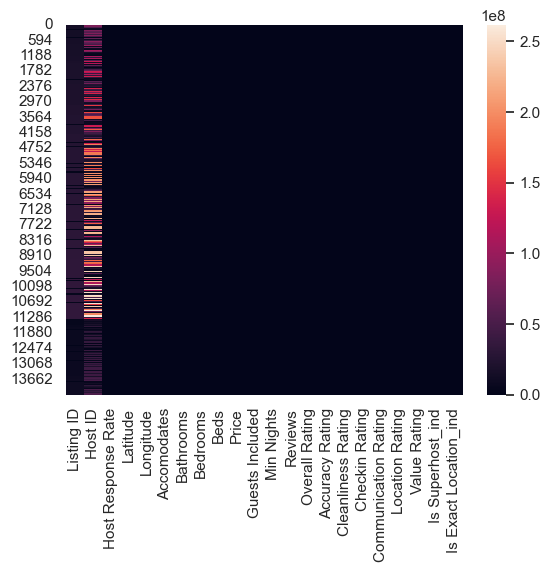

In [953]:
sns.heatmap(imputed_data) 

In [954]:
# Sort both DataFrames by their index
not_missing_df = not_missing_df.sort_index()
imputed_data = imputed_data.sort_index()

# Now, update the columns
not_missing_df[imp_cols] = imputed_data.values

In [955]:
not_missing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14251 entries, 65536 to 456958
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Listing ID             14251 non-null  float64       
 1   Listing Name           14226 non-null  string        
 2   Host ID                14251 non-null  float64       
 3   Host Name              14238 non-null  string        
 4   Host Since             14238 non-null  datetime64[ns]
 5   Host Response Time     8598 non-null   string        
 6   Host Response Rate     14251 non-null  float64       
 7   neighbourhood          14251 non-null  string        
 8   Neighborhood Group     14251 non-null  string        
 9   City                   14248 non-null  string        
 10  Country Code           14251 non-null  string        
 11  Latitude               14251 non-null  float64       
 12  Longitude              14251 non-null  float64       
 13  P

In [956]:

not_missing_df['City'].fillna('Berlin', inplace=True)
#For now, I've decided to fill the missing values in the `City` column with the name 'Berlin'.
#I'm strongly considering dropping the column in the next step.

In [957]:
def replace_nulls_with_missing(df, columns):
    for col in columns:
        df[col].fillna('Missing', inplace=True)

# Example usage:
columns_to_fill = ['Host Name', 'Listing Name', 'Host Response Time']
replace_nulls_with_missing(not_missing_df, columns_to_fill)

<Axes: >

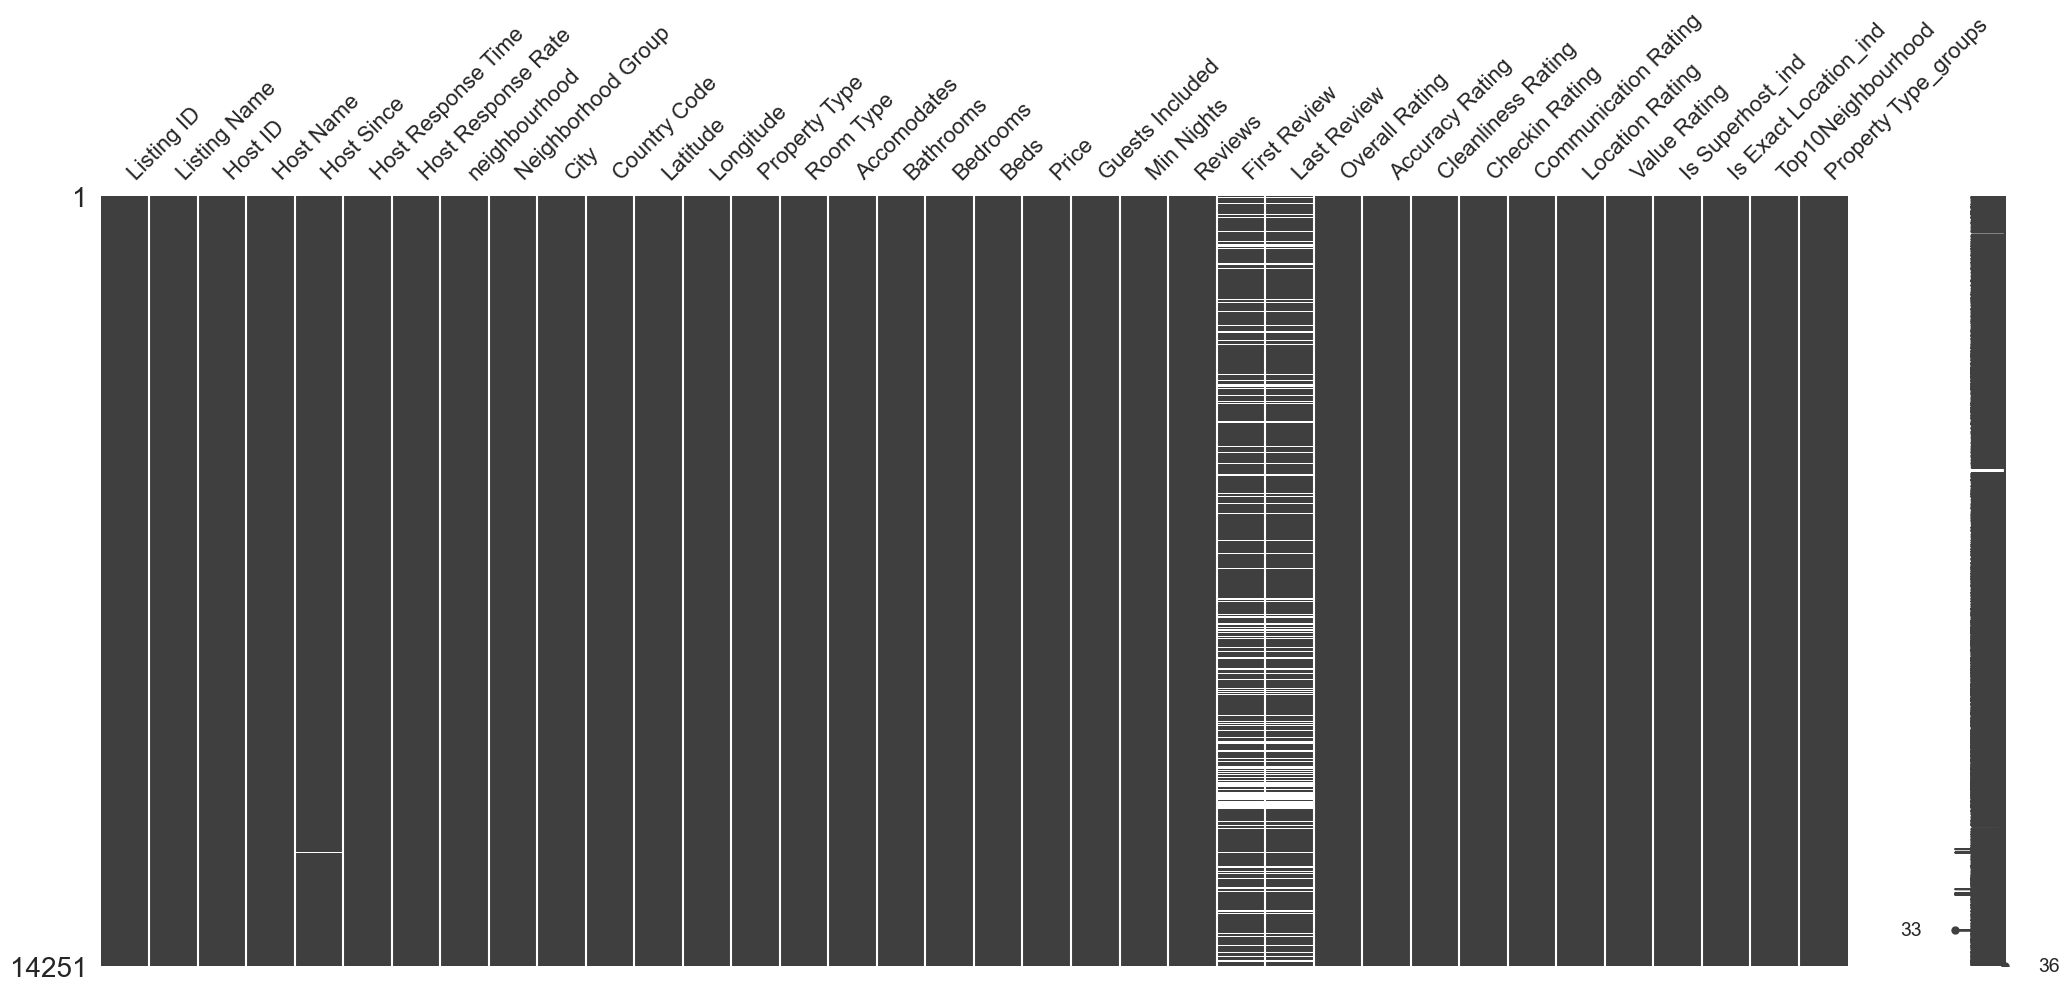

In [958]:
columns_with_nulls = not_missing_df.columns[not_missing_df.isnull().any()].tolist()
columns_with_nulls
#The missing values in the dates column will be handled in the feature engineering step.
msno.matrix(not_missing_df)

In [959]:
not_missing_df.to_pickle('step_3_df.pkl')